In [ ]:
!pip install mne
import mne
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install torch_geometric
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, balanced_accuracy_score, f1_score
from itertools import combinations
from tqdm.auto import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change with your own path

In [ ]:
target_dir = '/content/drive/MyDrive/Project/files' # Sergey's path

In [ ]:
edf_paths = sorted(glob.glob(os.path.join(target_dir, '**', '*.edf'), recursive = True))
print(f'{len(edf_paths)} EDG files')

KeyboardInterrupt: 

The code below generates a separate .npy file for each task. Each file follows the format {Subject ID}{Recording Session}\_{Task}\_{Movement/Imagine/Eyes in the case of no task (baselike recordings)}\_{rest/left/right/feet/fists depending on whether the task is to rest, close a fist, or close both fists or feet}\_{Epoch index}.npy

For example, S001R06_T1_imagine_fists_015.npy corresponds to the an epoch from subject 001's sixth recording session, where they perform task 1. Since this is session 6, this task is imagining closing both fists, and this is the 15th epoch of this task in this recording.

Each segment of each task is split up into windows of 1 second in length, with 0.5 seconds of overlap.



In [ ]:
# Return information about the task at hand
def run_info(run):
  if run == 1:
    return 'eyes_open' # Baseline task

  if run == 2:
    return 'eyes_closed' # Baseline

  if run == 3 or run == 7 or run == 11:
    return 'move' # Tasks correspond to closing and opening one fist

  if run == 4 or run == 8 or run == 12:
    return 'imagine' # Tasks correspond to imagining closing and opening one fist

  if run == 5 or run == 9 or run == 13:
    return 'move' # Tasks correspond to moving both fists or feet

  if run == 6 or run == 10 or run == 14:
    return 'imagine' # Tasks correspond to imagining moving both fists or feet

def task_info(code, run):
  if code == 'T0':
    return 'rest'

  if code == 'T1':
    if run in [3, 4, 7, 8, 11, 12]:
      return 'left'

    if run in [5, 6, 9, 10, 13, 14]:
      return 'fists'

  if code == 'T2':
    if run in [3, 4, 7, 8, 11, 12]:
      return 'right'

    if run in [5, 6, 9, 10, 13, 14]:
      return 'feet'

# Segment data into uniform window sizes. Window size is length (default one second), overlap is overlap in windows (default 0.5 seconds)
def segmenter(data, window_size = 1.0, overlap = 0.25):
  window = int(window_size * 160) # Window size in samples
  step = int(window * (1 -overlap)) # Step size in samples

  segments = []
  for start in range(0, data.shape[1] - window + 1, step):
    end = start + window
    segments.append(data[:, start:end])

  return np.array(segments)

# Function to count how many of each label
def count_labels(dataset, split):
  print(f'Class Counts for {split} Dataset')
  label_counts = {}

  # Look at all files in dataset
  for y in dataset.labels:
    label = int(y)
    label_counts[label] = label_counts.get(label, 0) + 1

  # Print counts
  for label, count in label_counts.items():
    print(f'Label {label}: {count} samples')

In [ ]:
# Build datasets
meta_data = [] # Information about samples
task_data = [] # Information about tasks

all_epochs = []
all_labels = []
all_subjects = []

# Directory to store datasets
task_dir = os.path.join(target_dir, 'Epoch Dataset')
if os.path.exists(task_dir):
  raise FileExistsError("Don't overwrite data")
else:
  os.makedirs(task_dir)

for file in edf_paths:
  print(f'Processing {file}')

  # Subject ID
  id = os.path.splitext(os.path.basename(file))[0]
  subject_id = id[:4]

  # Run number and task type
  run = int(re.search(r'R(\d+)', id).group(1))
  task_type = run_info(run)

  # Preprocess data
  raw = mne.io.read_raw_edf(file, preload = True, verbose = False)
  raw.filter(l_freq = 1, h_freq = 30, picks = ['eeg'], verbose = False)
  line_freqs = range(60, int(200 // 2), 60)
  raw = raw.notch_filter(freqs = line_freqs, picks = ['eeg', 'misc'], verbose = False)

  mne.set_eeg_reference(raw, ref_channels = 'average', copy = False, projection = False, verbose = False, ch_type = 'eeg')

  sfreq = float(raw.info['sfreq'])
  channels = raw.ch_names
  data = raw.get_data().astype(np.float32)
  duration = float(raw.n_times / raw.info['sfreq'])

  # Annotations
  annotations = raw.annotations
  if len(annotations) == 0:
    del raw, data
    gc.collect()
    continue

  annotated_df = annotations.to_data_frame()

  # Convert from date time to seconds
  annotated_df['onset'] = pd.to_datetime(annotated_df['onset'], errors = 'coerce')
  start_time = annotated_df['onset'].min()
  annotated_df['onset'] = (annotated_df['onset'] - start_time).dt.total_seconds()

  for index, row in annotated_df.iterrows():

    # Get task label, onset time, and description
    label = str(row['description'])
    onset = row['onset']
    dur = row['duration']
    limb = task_info(label, run)

    # Get class
    class_label = label_from_task(task_type, limb)
    if class_label is None:
      continue

    # Start and end indices of this task
    start = int(onset * sfreq)
    end = min(int((onset + dur) * sfreq), data.shape[1])

    # Recording segment for this task
    segment = data[:, start:end]

    # Split segment into epochs
    epochs = segmenter(segment, window_size = 2, overlap = 0.25)

    for i, epoch in enumerate(epochs):
      # Normalize epoch
      epoch = (epoch - epoch.mean(axis = 1, keepdims = True)) / (epoch.std(axis = 1, keepdims = True) + 1e-6)

      # Save this data
      task_name = f'{id}_{label}_{task_type}_{limb}_annotation{index}_{i:03d}'
      task_path = os.path.join(task_dir, f'{task_name}.npy')
      # np.save(task_path, epoch)

      task_data.append({
          'id': id,
          'run': run,
          'task_type': task_type,
          'task': label,
          'onset': onset,
          'duration': dur,
          'epoch_index': i,
          'path': task_path,
          'samples': epoch.shape[1],
          'subject': subject_id,
          'class_label': class_label})

      all_epochs.append(torch.tensor(epoch, dtype = torch.float))
      all_labels.append(torch.tensor(class_label, dtype = torch.long))
      all_subjects.append(subject_id)

  meta_data.append({'id': id,
                    'subject': subject_id,
                    'path': file,
                    'sfreq': sfreq,
                    'channels': channels,
                    'duration': duration})

  del raw, data
  gc.collect()

pd.DataFrame(meta_data).to_csv(os.path.join(task_dir, 'metadata.csv'), index = False)
pd.DataFrame(task_data).to_csv(os.path.join(task_dir, 'taskdata.csv'), index = False)

In [ ]:
# Save datasets
subjects = sorted(set(all_subjects))
train_subjects, test_subjects = train_test_split(subjects, test_size = 0.2, random_state = 10)
train_subjects, val_subjects = train_test_split(train_subjects, test_size = 0.25, random_state = 10)

# Function to split data based on subjects
def make_split(split):
  idxs = [i for i, subject in enumerate(all_subjects) if subject in split]
  split_data = torch.stack([all_epochs[i] for i in idxs])
  split_labels = torch.tensor([all_labels[i].item() for i in idxs])
  return EEGDataset(split_data, split_labels)

train_dataset = make_split(train_subjects)
val_dataset = make_split(val_subjects)
test_dataset = make_split(test_subjects)

print(f'Train samples: {len(train_dataset)}')
print(f'Val samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

# Save datasets so we don't have to create them everytime
save_dir = '/content/drive/MyDrive/Project/datasets'
os.makedirs(save_dir, exist_ok = True)
print("Save dir exists:", os.path.exists(save_dir))
print("Contents:", os.listdir(save_dir))

torch.save({'data': train_dataset.data, 'labels': train_dataset.labels}, os.path.join(save_dir, 'train_dataset.pt'))
torch.save({'data': val_dataset.data, 'labels': val_dataset.labels}, os.path.join(save_dir, 'val_dataset.pt'))
torch.save({'data': test_dataset.data, 'labels': test_dataset.labels}, os.path.join(save_dir, 'test_dataset.pt'))

print(os.listdir(save_dir))

In [ ]:
# Simple attention layer
class Attention(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.attention = nn.Linear(input_dim, 1)

  def forward(self, lstm_output):
    scores = torch.tanh(self.attention(lstm_output))
    weights = torch.softmax(scores, dim = 1)
    out = (lstm_output * weights).sum(dim = 1)
    return out

# CNN -> Bidirectional LSTM -> Attention, as in one of the papers
# There is no spatial combination in these convolutions, only across time.
# We might want to remove the groups parameter to change that.
class cnn_bilstm(nn.Module):
  def __init__(self, n_classes, hidden_size = 128, dropout = 0.2, kernel_size = 7):
    super().__init__()

    # Convolve across individual channels
    self.depth = nn.Conv1d(64, 64, kernel_size = 7, padding = 3, groups = 64)
    self.breadth = nn.Conv1d(64, 64, kernel_size = 1)

    # Batch norm and dropout
    self.bn = nn.BatchNorm1d(64)
    self.drop = nn.Dropout(dropout)

    # Bidirectional LSTM
    self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_size,
                        num_layers = 2, batch_first = True,
                        dropout = dropout, bidirectional = True)

    # Attention layer
    self.attention = Attention(hidden_size * 2)

    # Classification
    self.fc = nn.Sequential(nn.Linear(hidden_size * 2, hidden_size),
                            nn.ReLU(), nn.Dropout(dropout),
                            nn.Linear(hidden_size, n_classes)) # Multiply by 2 because bidirectional

  def forward(self, x):
    # Convolutions
    x = self.depth(x)
    x = self.breadth(x)

    # Bath norm and dropout
    x = self.bn(x)
    x = F.relu(x)
    x = self.drop(x)

    # Permute to (batch, time, features)
    x = x.permute(0, 2, 1)

    lstm_output, _ = self.lstm(x)
    lstm_features = self.attention(lstm_output)

    # Classify
    return self.fc(lstm_features)

In [ ]:
# CNN -> Transformer
class cnn_transformer(nn.Module):
  def __init__(self, n_classes, hidden_size = 128, dropout = 0.2, kernel_size = 7, nheads = 8):
    super().__init__()

    # Convolve across individual channels
    self.depth = nn.Conv1d(64, 64, kernel_size = 7, padding = 3, groups = 64)
    self.breadth = nn.Conv1d(64, 64, kernel_size = 1)

    # Batch norm and dropout
    self.bn = nn.BatchNorm1d(64)
    self.drop = nn.Dropout(dropout)

    # Transfomer
    encoder_layer = nn.TransformerEncoderLayer(d_model = 64, nhead = nheads, dropout = dropout,
                                               dim_feedforward = hidden_size * 4, batch_first = True)
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = 2)

    # Classification
    self.fc = nn.Sequential(nn.Linear(64, hidden_size),
                            nn.ReLU(), nn.Dropout(dropout),
                            nn.Linear(hidden_size, n_classes)) # Multiply by 2 because bidirectional

  def forward(self, x):
    # Convolutions
    x = self.depth(x)
    x = self.breadth(x)

    # Bath norm and dropout
    x = self.bn(x)
    x = F.relu(x)
    x = self.drop(x)

    # Permute to (batch, time, features)
    x = x.permute(0, 2, 1)

    x = self.transformer(x)
    features = x.mean(dim = 1)

    # Classify
    return self.fc(features)

In [ ]:
# CNN -> Bidirectional LSTM -> Transformer
class cnn_bilstm_transformer(nn.Module):
  def __init__(self, n_classes, hidden_size = 128, dropout = 0.2, kernel_size = 7, nheads = 8):
    super().__init__()

    # Convolve across individual channels
    self.depth = nn.Conv1d(64, 64, kernel_size = 7, padding = 3, groups = 64)
    self.breadth = nn.Conv1d(64, 64, kernel_size = 1)

    # Batch norm and dropout
    self.bn = nn.BatchNorm1d(64)
    self.drop = nn.Dropout(dropout)

    # Bidirectional LSTM
    self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_size,
                        num_layers = 2, batch_first = True,
                        dropout = dropout, bidirectional = True)

    # Transformer layer
    encoder_layer = nn.TransformerEncoderLayer(d_model = hidden_size * 2, nhead = nheads, dropout = dropout,
                                               dim_feedforward = hidden_size * 4, batch_first = True)
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = 2)

    # Classification
    self.fc = nn.Sequential(nn.Linear(hidden_size * 2, hidden_size),
                            nn.ReLU(), nn.Dropout(dropout),
                            nn.Linear(hidden_size, n_classes)) # Multiply by 2 because bidirectional

  def forward(self, x):
    # Convolutions
    x = self.depth(x)
    x = self.breadth(x)

    # Bath norm and dropout
    x = self.bn(x)
    x = F.relu(x)
    x = self.drop(x)

    # Permute to (batch, time, features)
    x = x.permute(0, 2, 1)

    lstm_output, _ = self.lstm(x)

    x = self.transformer(lstm_output)
    features = x.mean(dim = 1)

    # Classify
    return self.fc(features)

In [ ]:
# We were unable to make a dataset that works for this because preprocessing was extremely slow
# Convolution -> Graph with attention
class Graph(nn.Module):
  def __init__(self, n_classes, gat_hidden = 64, hidden_size = 128, heads = 4, dropout = 0.2):
    super().__init__()

    # Convolutions
    self.depth = nn.Conv1d(64, 64, kernel_size = 7, groups = 64, padding = 3)
    self.breadth = nn.Conv1d(64, 64, kernel_size = 1)
    self.bn1 = nn.BatchNorm1d(64)
    self.drop = nn.Dropout(dropout)

    # Graph with attention
    self.gat1 = GATv2Conv(64, gat_hidden, heads = heads, dropout = dropout)
    self.gat2 = GATv2Conv(gat_hidden * heads, gat_hidden, heads = 1, dropout = dropout)
    self.norm = nn.LayerNorm(gat_hidden)

    # Dense layer
    self.fc = nn.Sequential(nn.Linear(gat_hidden, hidden_size), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden_size, n_classes))

  def forward(self, x, edge_index, batch):
    x = self.depth(x)
    x = self.point(x)
    x = self.bn(x)
    x = F.relu(x)
    x = self.drop(x)
    x = x.mean(dim = -1).reshape(-1, 64)

    # Graph with attention
    x = self.gat1(x, edge_index)
    x = F.relu(x)
    x = self.gat2(x, edge_index)
    x = self.norm(x)

    # Global mean pooling (Should also try max pooling)
    x = global_mean_pool(x, batch)

    return self.fc(x)

In [ ]:
# Function to get label for different recordings
def label_from_task(task_type, limb):
  # Ignore baseline
  if task_type in ['eyes_open', 'eyes_closed']:
    return None

  # Rest is 0
  if limb == 'rest':
    return 0

  # Moving cases
  if task_type == 'move':
    mapping = {'fists': 1, 'feet': 2, 'right': 3, 'left': 4}
    return mapping.get(limb, None)

  # Imagery cases
  if task_type == 'imagine':
    mapping = {'fists': 5, 'feet': 6, 'right': 7, 'left': 8}
    return mapping.get(limb, None)

  return None

# Dataset class
class EEGDataset(Dataset):
  def __init__(self, data, labels, edge_index = None):
    self.data = data # Channels x time
    self.labels = labels

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    x = self.data[idx]
    y = self.labels[idx]
    return x, y

Function to choose subset of classes based on list of classes
For example, targets = [0, 1] would choose only rest and move fists as classes.
group = 'move' or 'imagine' would group those into a single label.

Mapping:
  * Rest: 0
  * Move:
    {'fists': 1, 'feet': 2, 'right': 3, 'left': 4}
  * Imagine:
    {'fists': 5, 'feet': 6, 'right': 7, 'left': 8}

In [ ]:
def subset_classes(dataset, targets, group = None):
  target_set = set(targets)

  # Allow for no groupings, one grouping, or multiple groupings
  if group is None:
    groups = []
  elif isinstance(group, str):
    groups = [group]
  else:
    groups = list(group)

  # Determine groupings
  move_labels = {1, 2, 3, 4}
  imagine_labels = {5, 6, 7, 8}
  rest_labels = {0}
  group_defs = {'move': move_labels, 'imagine': imagine_labels, 'rest': rest_labels}

  label_map = {}
  next_idx = 0

  # Make groupings
  grouped_labels = set()
  for group_name in groups:

    # Ignore unknown groups
    if group_name not in group_defs:
      continue

    # Assign labels to groups, if any
    group_labels = group_defs[group_name]
    labels_in_targets = sorted(target_set & group_labels)
    if not labels_in_targets:
      continue

    for label in labels_in_targets:
      label_map[label] = next_idx
      grouped_labels.add(label)
    next_idx += 1

  # Rest of labels
  remaining = sorted(target_set - grouped_labels)
  for label in remaining:
    label_map[label] = next_idx
    next_idx += 1

  # Mask to select samples in the dataset
  labels_np = dataset.labels.numpy()
  mask = torch.tensor([label in label_map for label in labels_np], dtype=torch.bool)

  new_data = dataset.data[mask]
  new_labels = dataset.labels[mask]

  # Remap labels
  new_labels = torch.tensor([label_map[int(l)] for l in new_labels], dtype = torch.long)

  # Return new dataset
  return EEGDataset(new_data, new_labels)

In [ ]:
# Load datasets
train_raw = torch.load('/content/drive/MyDrive/Project/datasets/train_dataset.pt', weights_only = False)
val_raw = torch.load('/content/drive/MyDrive/Project/datasets/val_dataset.pt', weights_only = False)
test_raw = torch.load('/content/drive/MyDrive/Project/datasets/test_dataset.pt', weights_only = False)
train_dataset_full = EEGDataset(train_raw['data'], train_raw['labels'])
val_dataset_full = EEGDataset(val_raw['data'], val_raw['labels'])
test_dataset_full = EEGDataset(test_raw['data'], test_raw['labels'])

# Adjust these based on classes of interest
## rest vs move vs imagine ##
# n_classes = 3
# targets = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# train_dataset = subset_classes(train_dataset_full, targets, group = ['move', 'imagine', 'rest'])
# val_dataset = subset_classes(val_dataset_full, targets, group = ['move', 'imagine', 'rest'])
# test_dataset = subset_classes(test_dataset_full, targets, group = ['move', 'imagine', 'rest'])

## rest vs imagine ##
# n_classes = 2
# targets = [0, 5, 6, 7, 8]
# train_dataset = subset_classes(train_dataset_full, targets, group = ['imagine', 'rest'])
# val_dataset = subset_classes(val_dataset_full, targets, group = ['imagine', 'rest'])
# test_dataset = subset_classes(test_dataset_full, targets, group = ['imagine', 'rest'])

## rest vs move ##
# n_classes = 2
# targets = [0, 1, 2, 3, 4]
# train_dataset = subset_classes(train_dataset_full, targets, group = ['move', 'rest'])
# val_dataset = subset_classes(val_dataset_full, targets, group = ['move', 'rest'])
# test_dataset = subset_classes(test_dataset_full, targets, group = ['move', 'rest'])

## move right vs left ##
# n_classes = 2
# targets = [3, 4]
# train_dataset = subset_classes(train_dataset_full, targets)
# val_dataset = subset_classes(val_dataset_full, targets)
# test_dataset = subset_classes(test_dataset_full, targets)

## imagine right vs left ##
# n_classes = 2
# targets = [7, 8]
# train_dataset = subset_classes(train_dataset_full, targets)
# val_dataset = subset_classes(val_dataset_full, targets)
# test_dataset = subset_classes(test_dataset_full, targets)

## all individual ##
n_classes = 9
targets = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_dataset = subset_classes(train_dataset_full, targets)
val_dataset = subset_classes(val_dataset_full, targets)
test_dataset = subset_classes(test_dataset_full, targets)

## move vs imagine ##
# n_classes = 2
# targets = [1, 2, 3, 4, 5, 6, 7, 8]
# train_dataset = subset_classes(train_dataset_full, targets, group = ['move', 'imagine'])
# val_dataset = subset_classes(val_dataset_full, targets, group = ['move', 'imagine'])
# test_dataset = subset_classes(test_dataset_full, targets, group = ['move', 'imagine'])

x, y = train_dataset[0]
print(f'Single sample: {x.shape}, Label: {y}')
print(f'Val samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

count_labels(train_dataset, 'Train')
count_labels(val_dataset, 'Val')
count_labels(test_dataset, 'Test')

# Get data loaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

for batch in train_loader:
    print("Batch loaded successfully!")
    break

val_loader = DataLoader(val_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)

Single sample: torch.Size([64, 320]), Label: 0
Val samples: 15868
Test samples: 15644
Class Counts for Train Dataset
Label 0: 22680 samples
Label 3: 2918 samples
Label 4: 2980 samples
Label 7: 2924 samples
Label 8: 2974 samples
Label 2: 2952 samples
Label 1: 2946 samples
Label 6: 2946 samples
Label 5: 2952 samples
Class Counts for Val Dataset
Label 0: 7934 samples
Label 3: 1010 samples
Label 4: 984 samples
Label 8: 1002 samples
Label 7: 978 samples
Label 2: 994 samples
Label 1: 986 samples
Label 6: 982 samples
Label 5: 998 samples
Class Counts for Test Dataset
Label 0: 7823 samples
Label 4: 978 samples
Label 3: 984 samples
Label 8: 983 samples
Label 7: 974 samples
Label 1: 948 samples
Label 2: 992 samples
Label 5: 980 samples
Label 6: 982 samples
Batch loaded successfully!


In [ ]:
# Function to train and evaluate a model
def train_evaluate(model, train_loader, val_loader,
                   epochs = 20, lr = 1e-4, patience = 3,
                   model_name = 'Model'):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  # Training set up
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = patience)

  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []
  best_val_loss = float('inf')
  best_model = os.path.join(target_dir, f'{model_name.replace(" ", "_")}_nodata.pt')

  # Train
  for epoch in tqdm(range(epochs), desc = f'Training {model_name}', leave = True):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
      optimizer.zero_grad()
      x, y = batch
      x = x.to(device)
      y = y.to(device)
      out = model(x)

      loss = criterion(out, y)
      loss.backward()
      optimizer.step()

      # Keep track of loss and proportion of correct predictions
      total_loss += loss.item() * y.size(0)
      correct += (out.argmax(1) == y).sum().item()
      total += y.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Evaluate
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for batch in val_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        out = model(x)

        loss = criterion(out, y)

        val_loss += loss.item() * y.size(0)
        val_correct += (out.argmax(1) == y).sum().item()
        val_total += y.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    scheduler.step(val_loss)

    # Save best model so far
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), best_model)

    # Keep track of metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    tqdm.write(f'Epoch {epoch + 1}: Train loss = {train_loss:.3f}, train accuracy = {train_acc:.3f}, val loss = {val_loss:.3f}, val accuracy = {val_acc:.3f}')

  # Plot loss vs epochs
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label = 'Training loss')
  plt.plot(val_losses, label = 'Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title(model_name)
  plt.show()

  # Plot accuracy vs epochs
  plt.figure()
  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label = 'Training Accuracy')
  plt.plot(val_accs, label = 'Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title(model_name)

  plt.tight_layout()
  plt.show()

  print(f'Best model saved to {best_model}')
  return best_model

def test_model(model, model_path, test_loader, class_names):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model.load_state_dict(torch.load(model_path))
  model = model.to(device)
  model.eval()

  y_true = []
  y_predicted = []
  y_probs = []

  with torch.no_grad():
    for batch in test_loader:
      x, y = batch
      x = x.to(device)
      y = y.to(device)
      out = model(x)

      probs = torch.softmax(out, dim = 1).cpu().numpy()
      preds = probs.argmax(axis = 1)

      y_probs.append(probs)
      y_true.append(y.cpu().numpy())
      y_predicted.append(preds)

  y_true = np.hstack(y_true)
  y_predicted = np.hstack(y_predicted)
  y_probs = np.vstack(y_probs)

  accuracy = accuracy_score(y_true, y_predicted)
  balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
  macro_f1 = f1_score(y_true, y_predicted, average = 'macro')
  cm = confusion_matrix(y_true, y_predicted)

  print(f"\nTest Accuracy: {accuracy:.3f}")
  print(f"Balanced Accuracy: {balanced_accuracy:.3f}")
  print(f"Macro F1 Score: {macro_f1:.3f}")

  n_classes = len(class_names)

  # Calculate AUC
  if n_classes == 2:
      auc_val = roc_auc_score(y_true, y_probs[:, 1])
      print(f"Binary AUC: {auc_val:.3f}")

      fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
      plt.plot(fpr, tpr, label = f"AUC = {auc_val:.3f}")
      plt.plot([0,1], [0,1], '--')
      plt.title("ROC Curve")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.legend()
      plt.show()

  else:
      auc_val = roc_auc_score(y_true, y_probs, multi_class = 'ovr', average = 'macro')
      print(f"Multiclass AUC (macro OVR): {auc_val:.3f}")

      # Plot one-per-class ROC
      for i in range(n_classes):
          fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
          plt.plot(fpr, tpr, label = f"{class_names[i]}")
      plt.plot([0,1], [0,1], '--')
      plt.title("Multiclass ROC Curve")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.legend()
      plt.show()

  plt.figure()
  sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = class_names, yticklabels = class_names, cmap = "Blues")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  return {"accuracy": accuracy, "balanced_accuracy": balanced_accuracy, "macro_f1": macro_f1, "auc": auc_val, "confusion_matrix": cm}

In [ ]:
placing this undefined code here to prevent code below from running automatically and removing plots

# Three below are rest vs imagine vs move

Training CNN -> LSTM:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 1.030, train accuracy = 0.490, val loss = 0.997, val accuracy = 0.511
Epoch 2: Train loss = 0.980, train accuracy = 0.515, val loss = 0.979, val accuracy = 0.531
Epoch 3: Train loss = 0.957, train accuracy = 0.534, val loss = 0.966, val accuracy = 0.530
Epoch 4: Train loss = 0.939, train accuracy = 0.549, val loss = 0.969, val accuracy = 0.529
Epoch 5: Train loss = 0.923, train accuracy = 0.557, val loss = 0.965, val accuracy = 0.540
Epoch 6: Train loss = 0.905, train accuracy = 0.572, val loss = 0.954, val accuracy = 0.549
Epoch 7: Train loss = 0.892, train accuracy = 0.581, val loss = 0.961, val accuracy = 0.540
Epoch 8: Train loss = 0.881, train accuracy = 0.587, val loss = 0.946, val accuracy = 0.550
Epoch 9: Train loss = 0.869, train accuracy = 0.595, val loss = 0.958, val accuracy = 0.552
Epoch 10: Train loss = 0.856, train accuracy = 0.602, val loss = 0.945, val accuracy = 0.556


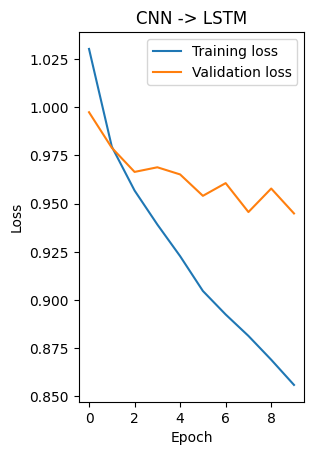

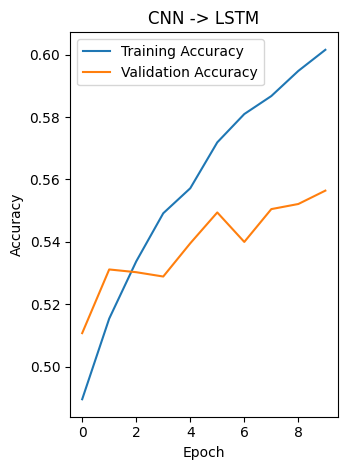

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_rest_imagine.pt


Training CNN -> Transformer:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 1.031, train accuracy = 0.491, val loss = 1.004, val accuracy = 0.516
Epoch 2: Train loss = 0.988, train accuracy = 0.515, val loss = 0.987, val accuracy = 0.498
Epoch 3: Train loss = 0.957, train accuracy = 0.536, val loss = 0.986, val accuracy = 0.507
Epoch 4: Train loss = 0.939, train accuracy = 0.550, val loss = 0.993, val accuracy = 0.511
Epoch 5: Train loss = 0.926, train accuracy = 0.560, val loss = 0.995, val accuracy = 0.518
Epoch 6: Train loss = 0.917, train accuracy = 0.563, val loss = 1.001, val accuracy = 0.522
Epoch 7: Train loss = 0.910, train accuracy = 0.569, val loss = 1.003, val accuracy = 0.520
Epoch 8: Train loss = 0.896, train accuracy = 0.578, val loss = 1.004, val accuracy = 0.526
Epoch 9: Train loss = 0.890, train accuracy = 0.582, val loss = 0.997, val accuracy = 0.534
Epoch 10: Train loss = 0.887, train accuracy = 0.583, val loss = 1.009, val accuracy = 0.528


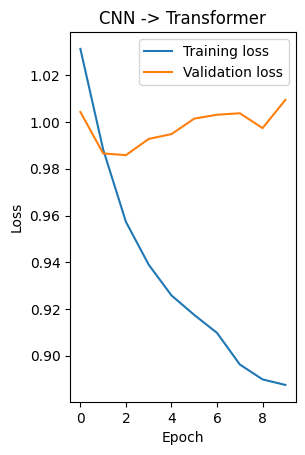

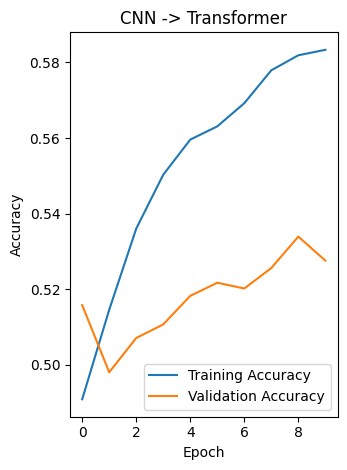

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_Transformer_rest_imagine.pt


Training CNN -> LSTM -> Transformer:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 1.031, train accuracy = 0.492, val loss = 1.007, val accuracy = 0.507
Epoch 2: Train loss = 0.992, train accuracy = 0.515, val loss = 0.990, val accuracy = 0.516
Epoch 3: Train loss = 0.961, train accuracy = 0.534, val loss = 0.966, val accuracy = 0.539
Epoch 4: Train loss = 0.935, train accuracy = 0.550, val loss = 0.959, val accuracy = 0.535
Epoch 5: Train loss = 0.913, train accuracy = 0.566, val loss = 0.971, val accuracy = 0.535
Epoch 6: Train loss = 0.897, train accuracy = 0.575, val loss = 0.964, val accuracy = 0.546
Epoch 7: Train loss = 0.877, train accuracy = 0.589, val loss = 1.000, val accuracy = 0.525
Epoch 8: Train loss = 0.857, train accuracy = 0.602, val loss = 1.000, val accuracy = 0.531
Epoch 9: Train loss = 0.823, train accuracy = 0.623, val loss = 0.969, val accuracy = 0.547
Epoch 10: Train loss = 0.805, train accuracy = 0.631, val loss = 1.028, val accuracy = 0.533


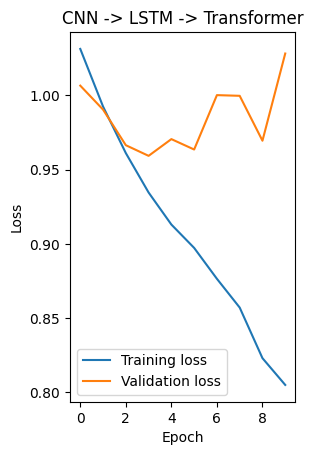

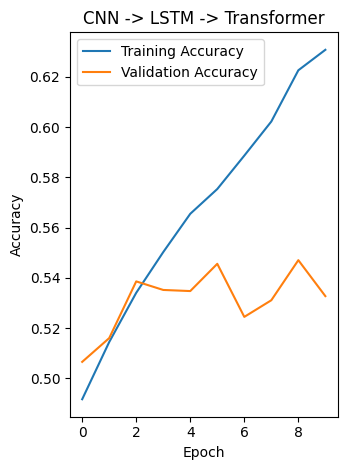

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_rest_imagine.pt


In [ ]:
lstm_path = train_evaluate(model = cnn_bilstm(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM')
tf_path = train_evaluate(model = cnn_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> Transformer')
lstmtf_path = train_evaluate(model = cnn_bilstm_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM -> Transformer')


Test Accuracy: 0.529
Balanced Accuracy: 0.465
Macro F1 Score: 0.462
Multiclass AUC (macro OVR): 0.691


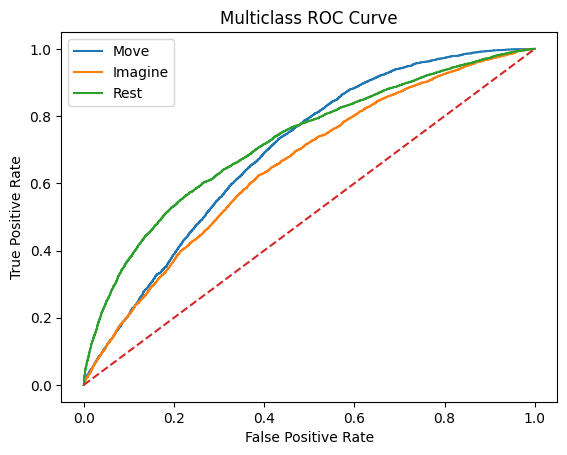

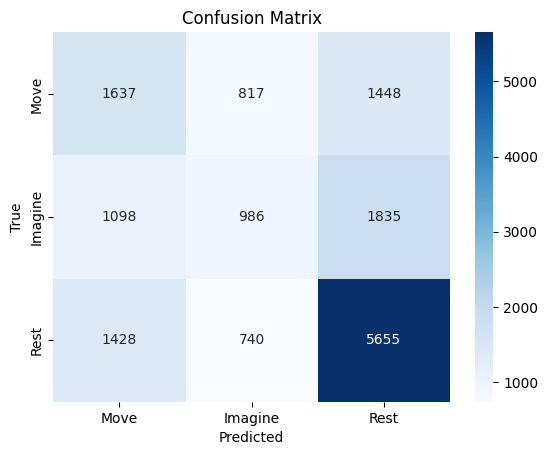


Test Accuracy: 0.506
Balanced Accuracy: 0.437
Macro F1 Score: 0.434
Multiclass AUC (macro OVR): 0.661


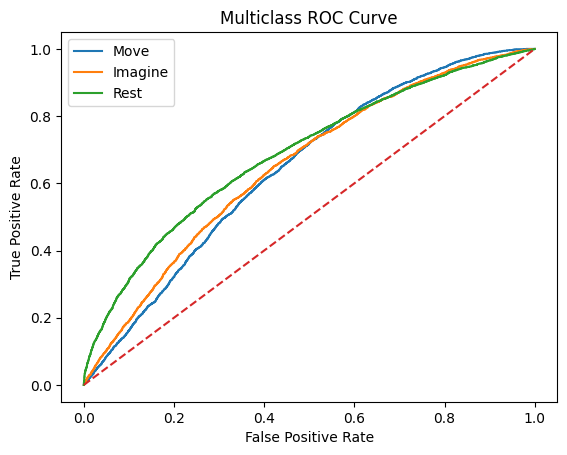

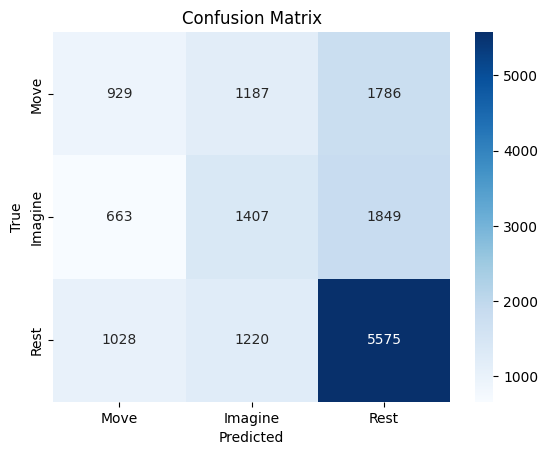


Test Accuracy: 0.525
Balanced Accuracy: 0.448
Macro F1 Score: 0.443
Multiclass AUC (macro OVR): 0.676


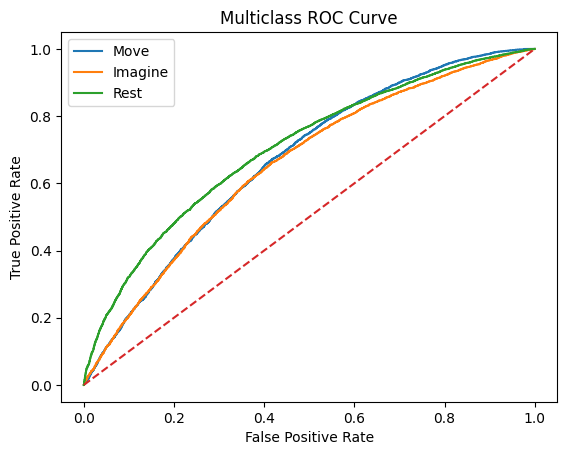

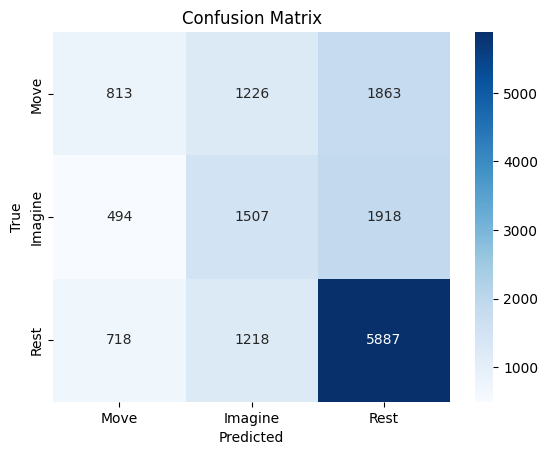

In [ ]:
lstm_path = '/content/drive/MyDrive/Project/files/CNN_->_LSTM_rest_move_imagine.pt'
tf_path = '/content/drive/MyDrive/Project/files/CNN_->_Transformer_rest_move_imagine.pt'
lstmtf_path = '/content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_rest_move_imagine.pt'
resuls_cnn_lstm = test_model(model = cnn_bilstm(n_classes), model_path = lstm_path,
                            test_loader = test_loader, class_names = ["Move", "Imagine", "Rest"])
resuls_cnn_tf = test_model(model = cnn_transformer(n_classes), model_path = tf_path,
                            test_loader = test_loader, class_names = ["Move", "Imagine", "Rest"])
resuls_cnn_lstm_tf = test_model(model = cnn_bilstm_transformer(n_classes), model_path = lstmtf_path,
                            test_loader = test_loader, class_names = ["Move", "Imagine", "Rest"])

# Three below are rest vs imagine

Training CNN -> LSTM:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.627, train accuracy = 0.659, val loss = 0.606, val accuracy = 0.679
Epoch 2: Train loss = 0.605, train accuracy = 0.676, val loss = 0.593, val accuracy = 0.692
Epoch 3: Train loss = 0.587, train accuracy = 0.692, val loss = 0.593, val accuracy = 0.695
Epoch 4: Train loss = 0.572, train accuracy = 0.704, val loss = 0.591, val accuracy = 0.694
Epoch 5: Train loss = 0.559, train accuracy = 0.714, val loss = 0.590, val accuracy = 0.684
Epoch 6: Train loss = 0.550, train accuracy = 0.720, val loss = 0.593, val accuracy = 0.686
Epoch 7: Train loss = 0.540, train accuracy = 0.728, val loss = 0.584, val accuracy = 0.695
Epoch 8: Train loss = 0.531, train accuracy = 0.736, val loss = 0.581, val accuracy = 0.695
Epoch 9: Train loss = 0.524, train accuracy = 0.739, val loss = 0.624, val accuracy = 0.664
Epoch 10: Train loss = 0.517, train accuracy = 0.744, val loss = 0.655, val accuracy = 0.645


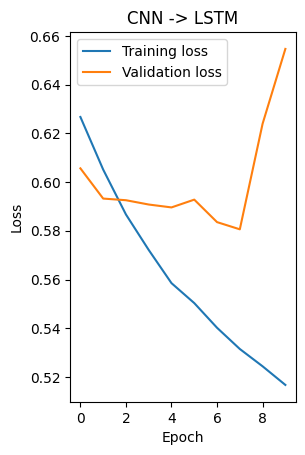

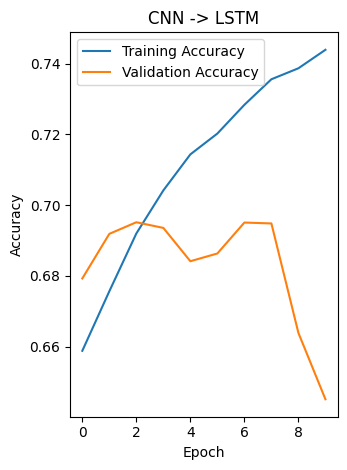

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_rest_imagine.pt


Training CNN -> Transformer:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.623, train accuracy = 0.660, val loss = 0.602, val accuracy = 0.685
Epoch 2: Train loss = 0.599, train accuracy = 0.679, val loss = 0.601, val accuracy = 0.680
Epoch 3: Train loss = 0.583, train accuracy = 0.692, val loss = 0.621, val accuracy = 0.639
Epoch 4: Train loss = 0.571, train accuracy = 0.702, val loss = 0.609, val accuracy = 0.690
Epoch 5: Train loss = 0.561, train accuracy = 0.710, val loss = 0.623, val accuracy = 0.683
Epoch 6: Train loss = 0.555, train accuracy = 0.716, val loss = 0.603, val accuracy = 0.685
Epoch 7: Train loss = 0.544, train accuracy = 0.724, val loss = 0.636, val accuracy = 0.692
Epoch 8: Train loss = 0.541, train accuracy = 0.725, val loss = 0.630, val accuracy = 0.692
Epoch 9: Train loss = 0.539, train accuracy = 0.729, val loss = 0.610, val accuracy = 0.683
Epoch 10: Train loss = 0.537, train accuracy = 0.729, val loss = 0.630, val accuracy = 0.691


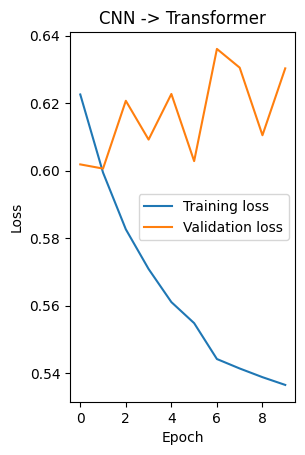

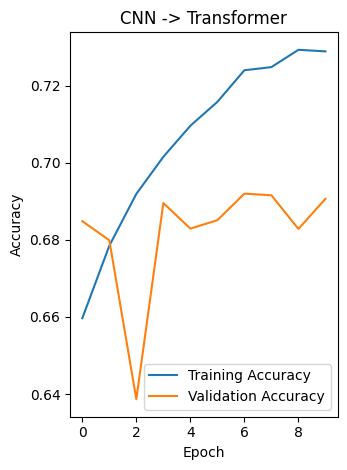

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_Transformer_rest_imagine.pt


Training CNN -> LSTM -> Transformer:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.627, train accuracy = 0.657, val loss = 0.617, val accuracy = 0.669
Epoch 2: Train loss = 0.607, train accuracy = 0.673, val loss = 0.591, val accuracy = 0.693
Epoch 3: Train loss = 0.587, train accuracy = 0.692, val loss = 0.586, val accuracy = 0.692
Epoch 4: Train loss = 0.568, train accuracy = 0.707, val loss = 0.583, val accuracy = 0.698
Epoch 5: Train loss = 0.555, train accuracy = 0.716, val loss = 0.584, val accuracy = 0.703
Epoch 6: Train loss = 0.539, train accuracy = 0.729, val loss = 0.584, val accuracy = 0.700
Epoch 7: Train loss = 0.527, train accuracy = 0.736, val loss = 0.582, val accuracy = 0.706
Epoch 8: Train loss = 0.516, train accuracy = 0.745, val loss = 0.612, val accuracy = 0.683
Epoch 9: Train loss = 0.501, train accuracy = 0.755, val loss = 0.603, val accuracy = 0.702
Epoch 10: Train loss = 0.485, train accuracy = 0.767, val loss = 0.575, val accuracy = 0.711


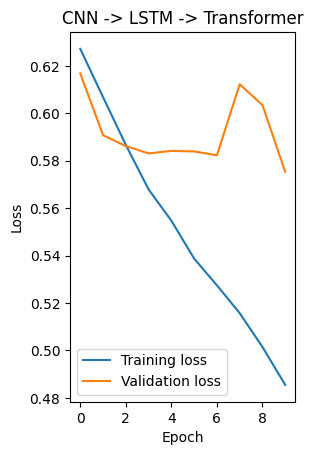

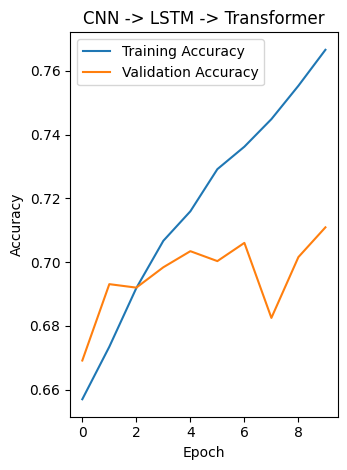

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_rest_imagine.pt


In [ ]:
lstm_path = train_evaluate(model = cnn_bilstm(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM')
tf_path = train_evaluate(model = cnn_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> Transformer')
lstmtf_path = train_evaluate(model = cnn_bilstm_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM -> Transformer')


Test Accuracy: 0.701
Balanced Accuracy: 0.619
Macro F1 Score: 0.624
Binary AUC: 0.705


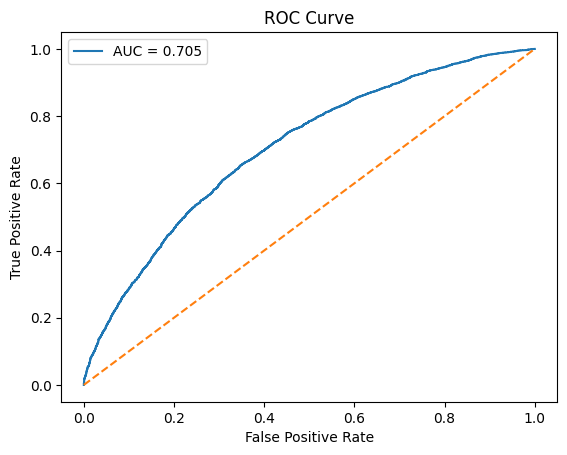

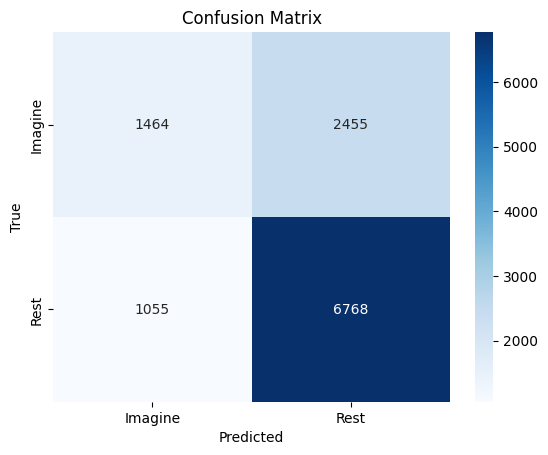


Test Accuracy: 0.677
Balanced Accuracy: 0.622
Macro F1 Score: 0.625
Binary AUC: 0.687


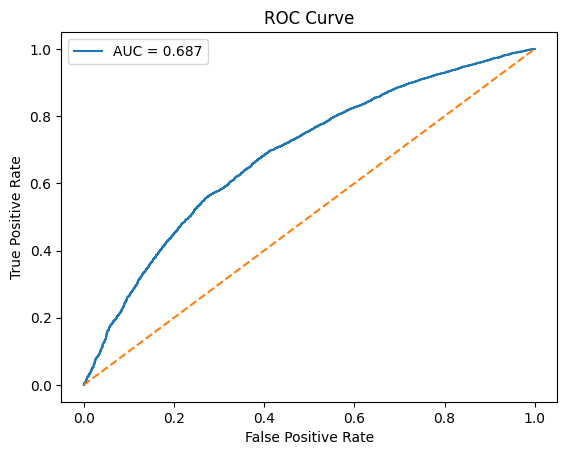

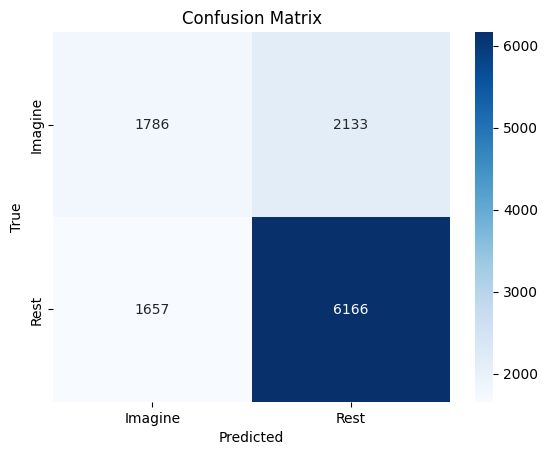


Test Accuracy: 0.693
Balanced Accuracy: 0.637
Macro F1 Score: 0.641
Binary AUC: 0.703


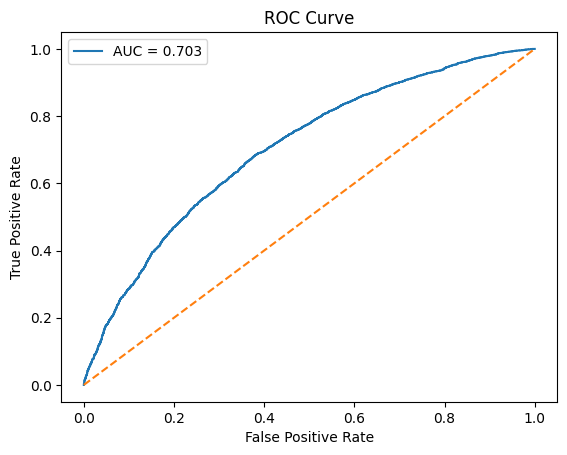

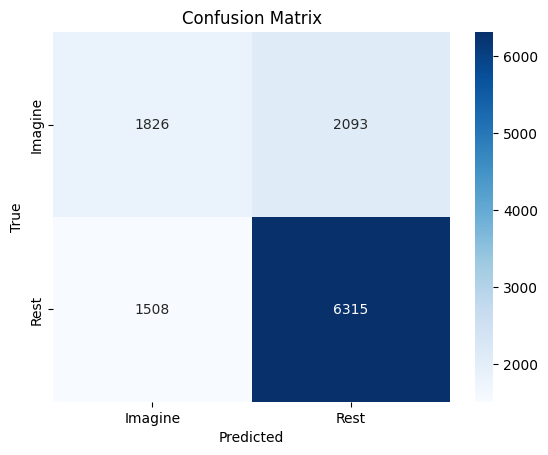

In [ ]:
resuls_cnn_lstm = test_model(model = cnn_bilstm(n_classes), model_path = lstm_path,
                            test_loader = test_loader, class_names = ["Imagine", "Rest"])
resuls_cnn_tf = test_model(model = cnn_transformer(n_classes), model_path = tf_path,
                            test_loader = test_loader, class_names = ["Imagine", "Rest"])
resuls_cnn_lstm_tf = test_model(model = cnn_bilstm_transformer(n_classes), model_path = lstmtf_path,
                            test_loader = test_loader, class_names = ["Imagine", "Rest"])

# Three below are rest vs move

Training CNN -> LSTM:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.630, train accuracy = 0.659, val loss = 0.618, val accuracy = 0.639
Epoch 2: Train loss = 0.578, train accuracy = 0.685, val loss = 0.577, val accuracy = 0.692
Epoch 3: Train loss = 0.544, train accuracy = 0.714, val loss = 0.561, val accuracy = 0.693
Epoch 4: Train loss = 0.527, train accuracy = 0.725, val loss = 0.561, val accuracy = 0.705
Epoch 5: Train loss = 0.508, train accuracy = 0.744, val loss = 0.549, val accuracy = 0.716
Epoch 6: Train loss = 0.499, train accuracy = 0.752, val loss = 0.552, val accuracy = 0.709
Epoch 7: Train loss = 0.488, train accuracy = 0.761, val loss = 0.537, val accuracy = 0.730
Epoch 8: Train loss = 0.477, train accuracy = 0.766, val loss = 0.558, val accuracy = 0.715
Epoch 9: Train loss = 0.468, train accuracy = 0.771, val loss = 0.532, val accuracy = 0.731
Epoch 10: Train loss = 0.459, train accuracy = 0.776, val loss = 0.565, val accuracy = 0.722


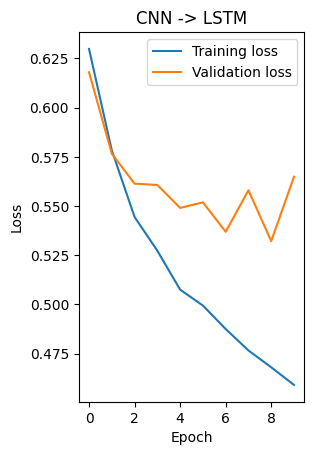

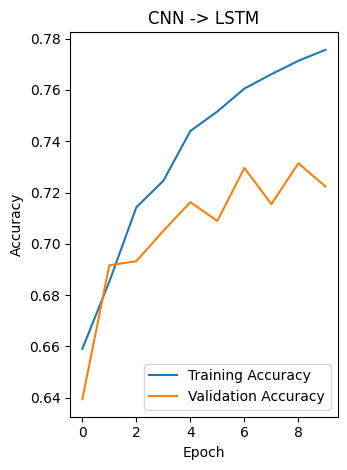

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_rest_move.pt


Training CNN -> Transformer:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.626, train accuracy = 0.660, val loss = 0.633, val accuracy = 0.603
Epoch 2: Train loss = 0.575, train accuracy = 0.690, val loss = 0.587, val accuracy = 0.673
Epoch 3: Train loss = 0.551, train accuracy = 0.708, val loss = 0.595, val accuracy = 0.685
Epoch 4: Train loss = 0.535, train accuracy = 0.718, val loss = 0.601, val accuracy = 0.676
Epoch 5: Train loss = 0.524, train accuracy = 0.728, val loss = 0.613, val accuracy = 0.670
Epoch 6: Train loss = 0.514, train accuracy = 0.736, val loss = 0.626, val accuracy = 0.662
Epoch 7: Train loss = 0.504, train accuracy = 0.741, val loss = 0.631, val accuracy = 0.662
Epoch 8: Train loss = 0.501, train accuracy = 0.746, val loss = 0.611, val accuracy = 0.676
Epoch 9: Train loss = 0.495, train accuracy = 0.751, val loss = 0.597, val accuracy = 0.690
Epoch 10: Train loss = 0.492, train accuracy = 0.752, val loss = 0.607, val accuracy = 0.682


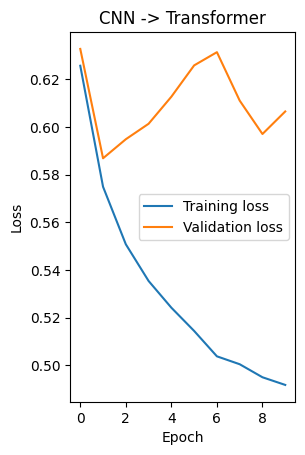

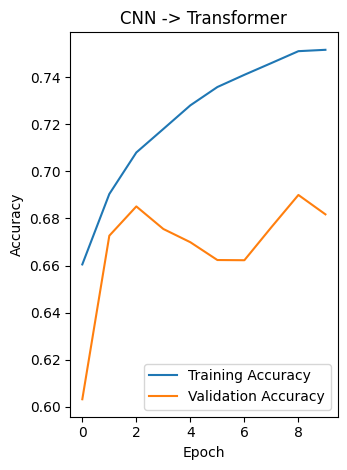

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_Transformer_rest_move.pt


Training CNN -> LSTM -> Transformer:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.634, train accuracy = 0.660, val loss = 0.600, val accuracy = 0.678
Epoch 2: Train loss = 0.581, train accuracy = 0.688, val loss = 0.578, val accuracy = 0.688
Epoch 3: Train loss = 0.548, train accuracy = 0.717, val loss = 0.570, val accuracy = 0.709
Epoch 4: Train loss = 0.526, train accuracy = 0.733, val loss = 0.560, val accuracy = 0.703
Epoch 5: Train loss = 0.504, train accuracy = 0.744, val loss = 0.557, val accuracy = 0.721
Epoch 6: Train loss = 0.489, train accuracy = 0.760, val loss = 0.558, val accuracy = 0.727
Epoch 7: Train loss = 0.477, train accuracy = 0.765, val loss = 0.555, val accuracy = 0.729
Epoch 8: Train loss = 0.457, train accuracy = 0.779, val loss = 0.548, val accuracy = 0.732
Epoch 9: Train loss = 0.442, train accuracy = 0.787, val loss = 0.608, val accuracy = 0.703
Epoch 10: Train loss = 0.423, train accuracy = 0.800, val loss = 0.576, val accuracy = 0.724


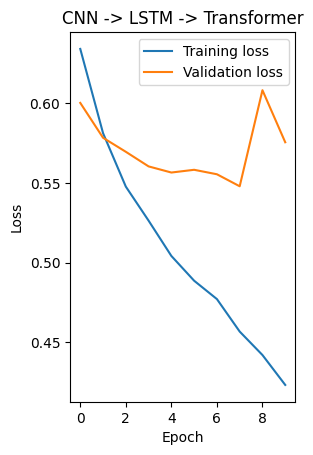

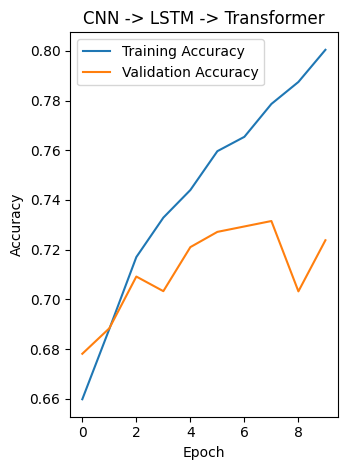

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_rest_move.pt


In [ ]:
lstm_path = train_evaluate(model = cnn_bilstm(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM')
tf_path = train_evaluate(model = cnn_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> Transformer')
lstmtf_path = train_evaluate(model = cnn_bilstm_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM -> Transformer')


Test Accuracy: 0.708
Balanced Accuracy: 0.629
Macro F1 Score: 0.636
Binary AUC: 0.753


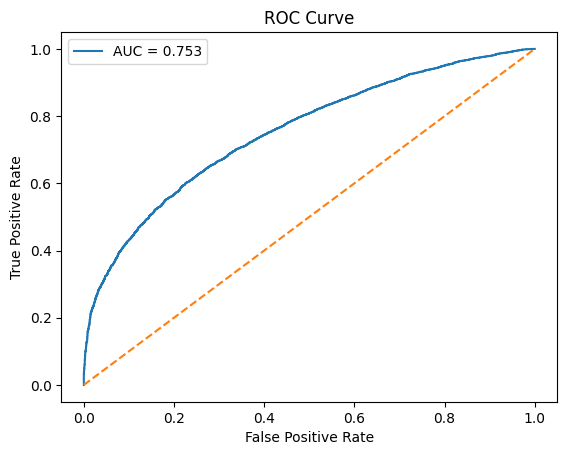

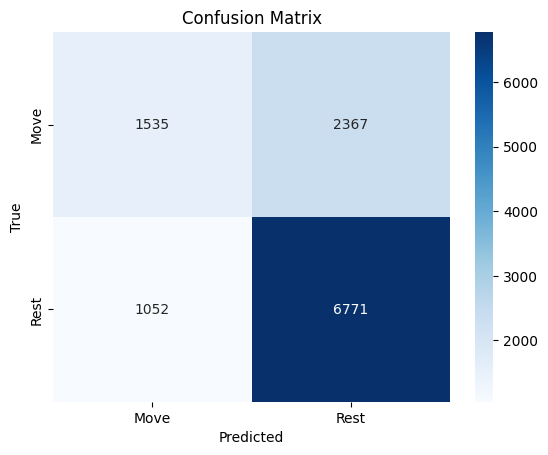


Test Accuracy: 0.648
Balanced Accuracy: 0.615
Macro F1 Score: 0.612
Binary AUC: 0.684


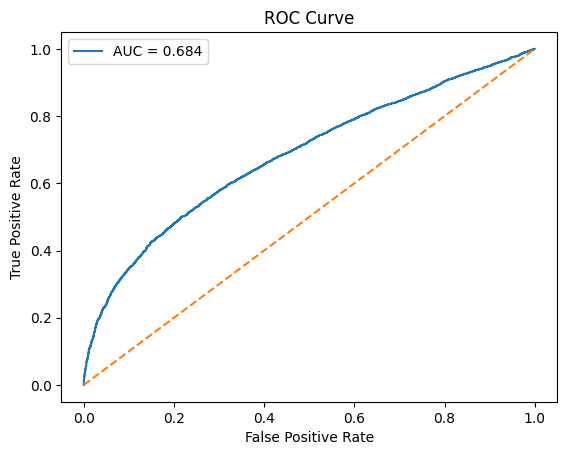

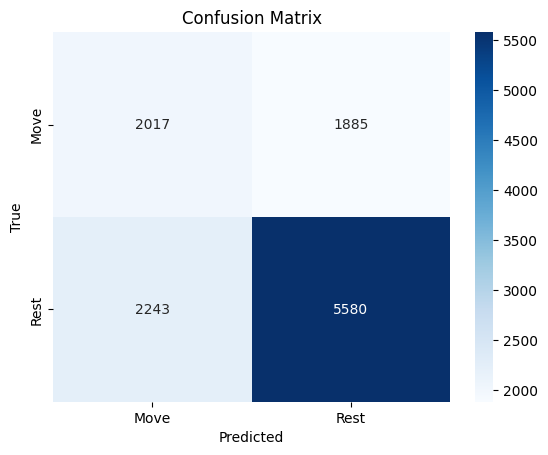


Test Accuracy: 0.704
Balanced Accuracy: 0.651
Macro F1 Score: 0.655
Binary AUC: 0.749


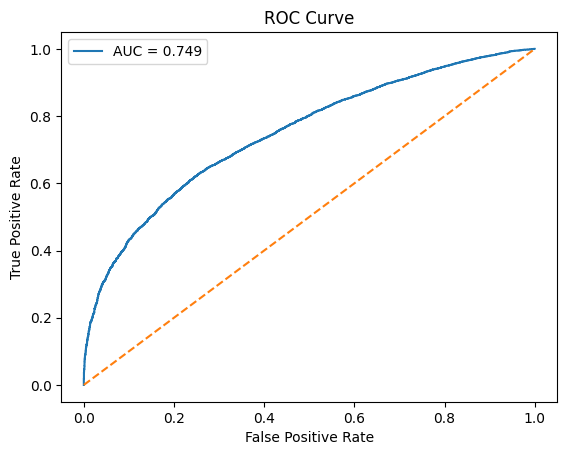

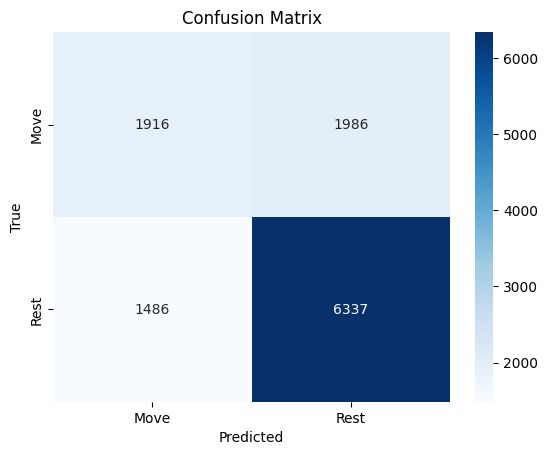

In [ ]:
resuls_cnn_lstm = test_model(model = cnn_bilstm(n_classes), model_path = lstm_path,
                            test_loader = test_loader, class_names = ["Move", "Rest"])
resuls_cnn_tf = test_model(model = cnn_transformer(n_classes), model_path = tf_path,
                            test_loader = test_loader, class_names = ["Move", "Rest"])
resuls_cnn_lstm_tf = test_model(model = cnn_bilstm_transformer(n_classes), model_path = lstmtf_path,
                            test_loader = test_loader, class_names = ["Move", "Rest"])

# Three below are move right versus left

Training CNN -> LSTM:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.693, train accuracy = 0.496, val loss = 0.693, val accuracy = 0.493
Epoch 2: Train loss = 0.691, train accuracy = 0.525, val loss = 0.680, val accuracy = 0.567
Epoch 3: Train loss = 0.672, train accuracy = 0.581, val loss = 0.642, val accuracy = 0.627
Epoch 4: Train loss = 0.639, train accuracy = 0.625, val loss = 0.606, val accuracy = 0.654
Epoch 5: Train loss = 0.613, train accuracy = 0.654, val loss = 0.589, val accuracy = 0.676
Epoch 6: Train loss = 0.597, train accuracy = 0.662, val loss = 0.606, val accuracy = 0.662
Epoch 7: Train loss = 0.582, train accuracy = 0.679, val loss = 0.568, val accuracy = 0.682
Epoch 8: Train loss = 0.568, train accuracy = 0.691, val loss = 0.568, val accuracy = 0.688
Epoch 9: Train loss = 0.552, train accuracy = 0.703, val loss = 0.564, val accuracy = 0.693
Epoch 10: Train loss = 0.538, train accuracy = 0.714, val loss = 0.567, val accuracy = 0.693
Epoch 11: Train loss = 0.526, train accuracy = 0.727, val loss = 0.565, val acc

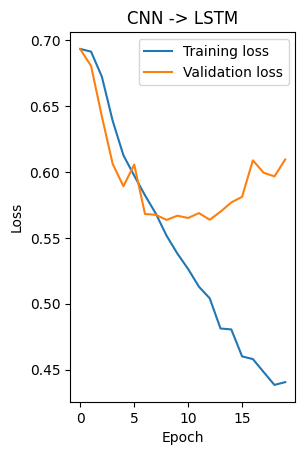

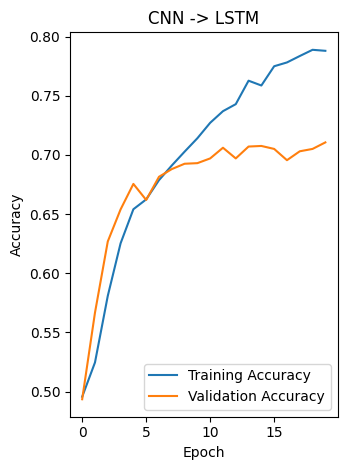

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_right_left_move.pt


Training CNN -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.694, train accuracy = 0.517, val loss = 0.690, val accuracy = 0.535
Epoch 2: Train loss = 0.689, train accuracy = 0.531, val loss = 0.678, val accuracy = 0.583
Epoch 3: Train loss = 0.678, train accuracy = 0.571, val loss = 0.665, val accuracy = 0.582
Epoch 4: Train loss = 0.663, train accuracy = 0.592, val loss = 0.644, val accuracy = 0.614
Epoch 5: Train loss = 0.646, train accuracy = 0.613, val loss = 0.622, val accuracy = 0.642
Epoch 6: Train loss = 0.633, train accuracy = 0.634, val loss = 0.610, val accuracy = 0.652
Epoch 7: Train loss = 0.629, train accuracy = 0.646, val loss = 0.619, val accuracy = 0.651
Epoch 8: Train loss = 0.616, train accuracy = 0.653, val loss = 0.602, val accuracy = 0.670
Epoch 9: Train loss = 0.609, train accuracy = 0.661, val loss = 0.599, val accuracy = 0.669
Epoch 10: Train loss = 0.602, train accuracy = 0.675, val loss = 0.596, val accuracy = 0.676
Epoch 11: Train loss = 0.595, train accuracy = 0.683, val loss = 0.599, val acc

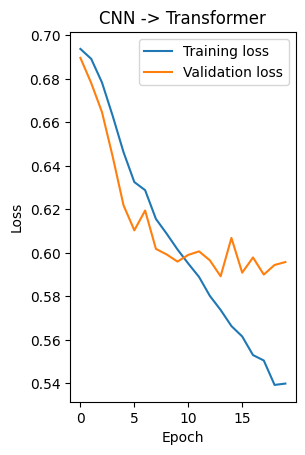

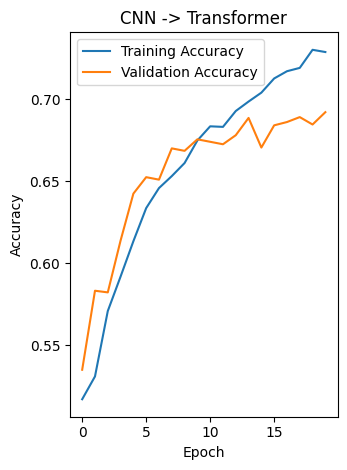

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_Transformer_right_left_move.pt


Training CNN -> LSTM -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.698, train accuracy = 0.505, val loss = 0.694, val accuracy = 0.493
Epoch 2: Train loss = 0.695, train accuracy = 0.495, val loss = 0.692, val accuracy = 0.493
Epoch 3: Train loss = 0.682, train accuracy = 0.556, val loss = 0.681, val accuracy = 0.588
Epoch 4: Train loss = 0.667, train accuracy = 0.588, val loss = 0.639, val accuracy = 0.621
Epoch 5: Train loss = 0.646, train accuracy = 0.629, val loss = 0.623, val accuracy = 0.645
Epoch 6: Train loss = 0.629, train accuracy = 0.643, val loss = 0.616, val accuracy = 0.646
Epoch 7: Train loss = 0.605, train accuracy = 0.669, val loss = 0.589, val accuracy = 0.663
Epoch 8: Train loss = 0.586, train accuracy = 0.685, val loss = 0.571, val accuracy = 0.679
Epoch 9: Train loss = 0.562, train accuracy = 0.699, val loss = 0.590, val accuracy = 0.670
Epoch 10: Train loss = 0.538, train accuracy = 0.715, val loss = 0.571, val accuracy = 0.688
Epoch 11: Train loss = 0.524, train accuracy = 0.728, val loss = 0.590, val acc

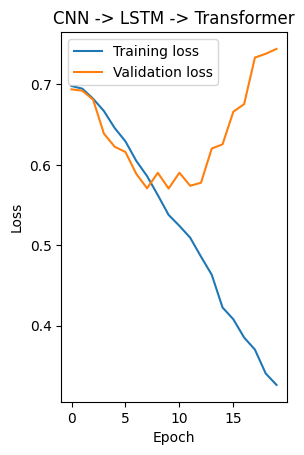

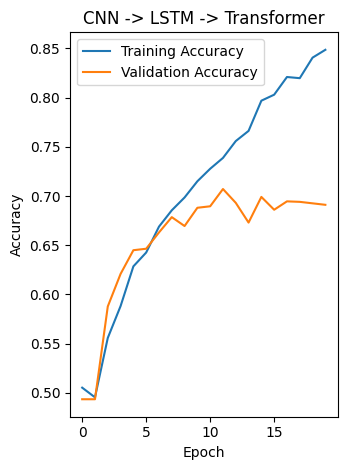

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_right_left_move.pt


In [ ]:
lstm_path = train_evaluate(model = cnn_bilstm(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM')
tf_path = train_evaluate(model = cnn_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> Transformer')
lstmtf_path = train_evaluate(model = cnn_bilstm_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM -> Transformer')


Test Accuracy: 0.665
Balanced Accuracy: 0.665
Macro F1 Score: 0.655
Binary AUC: 0.758


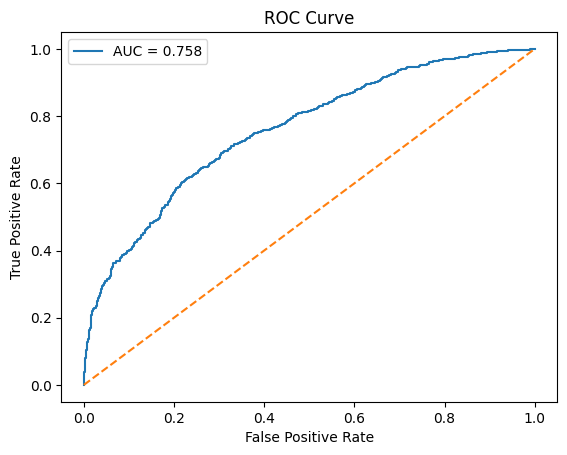

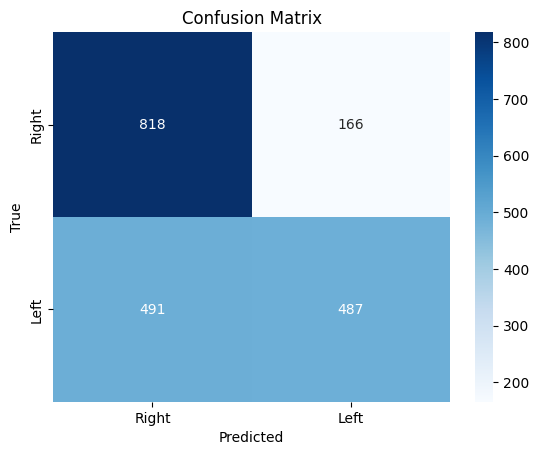


Test Accuracy: 0.631
Balanced Accuracy: 0.631
Macro F1 Score: 0.630
Binary AUC: 0.699


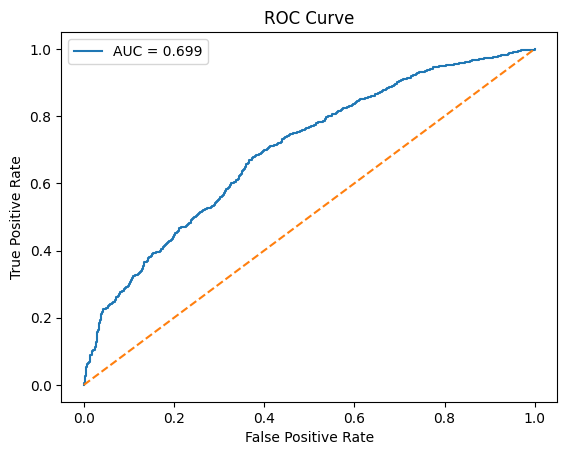

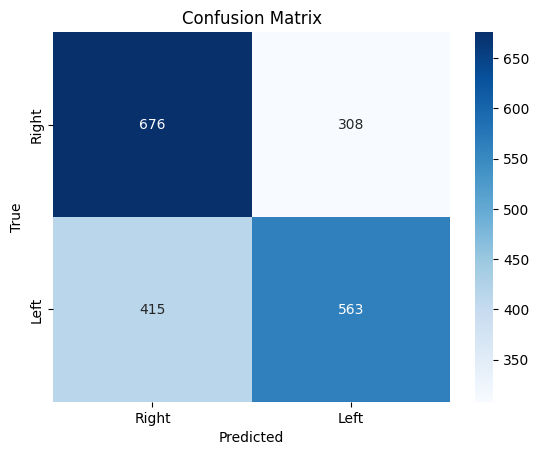


Test Accuracy: 0.645
Balanced Accuracy: 0.645
Macro F1 Score: 0.642
Binary AUC: 0.729


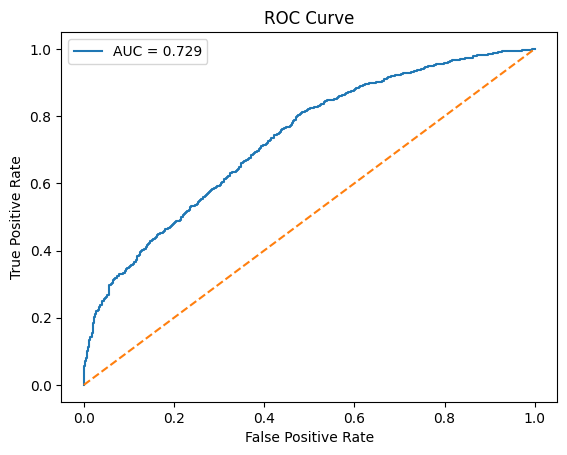

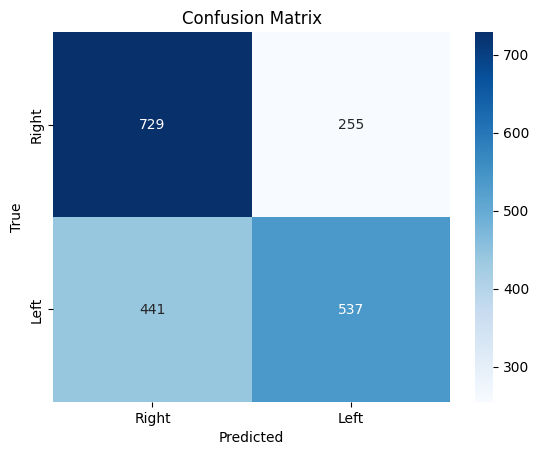

In [ ]:
resuls_cnn_lstm = test_model(model = cnn_bilstm(n_classes), model_path = lstm_path,
                            test_loader = test_loader, class_names = ["Right", "Left"])
resuls_cnn_tf = test_model(model = cnn_transformer(n_classes), model_path = tf_path,
                            test_loader = test_loader, class_names = ["Right", "Left"])
resuls_cnn_lstm_tf = test_model(model = cnn_bilstm_transformer(n_classes), model_path = lstmtf_path,
                            test_loader = test_loader, class_names = ["Right", "Left"])

# Three below are imagine right vs left

Training CNN -> LSTM:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.694, train accuracy = 0.500, val loss = 0.693, val accuracy = 0.494
Epoch 2: Train loss = 0.693, train accuracy = 0.509, val loss = 0.692, val accuracy = 0.507
Epoch 3: Train loss = 0.690, train accuracy = 0.533, val loss = 0.674, val accuracy = 0.559
Epoch 4: Train loss = 0.651, train accuracy = 0.603, val loss = 0.616, val accuracy = 0.638
Epoch 5: Train loss = 0.617, train accuracy = 0.636, val loss = 0.634, val accuracy = 0.626
Epoch 6: Train loss = 0.591, train accuracy = 0.661, val loss = 0.577, val accuracy = 0.677
Epoch 7: Train loss = 0.580, train accuracy = 0.664, val loss = 0.562, val accuracy = 0.688
Epoch 8: Train loss = 0.566, train accuracy = 0.683, val loss = 0.565, val accuracy = 0.682
Epoch 9: Train loss = 0.554, train accuracy = 0.689, val loss = 0.578, val accuracy = 0.669
Epoch 10: Train loss = 0.542, train accuracy = 0.704, val loss = 0.567, val accuracy = 0.680
Epoch 11: Train loss = 0.528, train accuracy = 0.720, val loss = 0.579, val acc

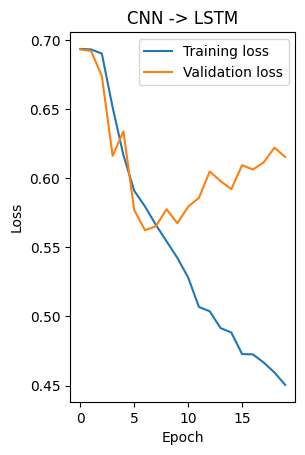

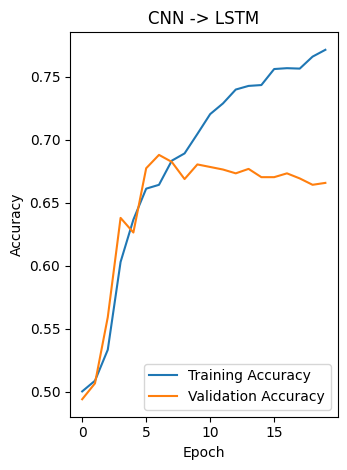

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_right_left_imagine.pt


Training CNN -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.694, train accuracy = 0.499, val loss = 0.693, val accuracy = 0.494
Epoch 2: Train loss = 0.692, train accuracy = 0.524, val loss = 0.685, val accuracy = 0.538
Epoch 3: Train loss = 0.682, train accuracy = 0.566, val loss = 0.664, val accuracy = 0.609
Epoch 4: Train loss = 0.669, train accuracy = 0.587, val loss = 0.628, val accuracy = 0.645
Epoch 5: Train loss = 0.646, train accuracy = 0.616, val loss = 0.609, val accuracy = 0.652
Epoch 6: Train loss = 0.628, train accuracy = 0.643, val loss = 0.609, val accuracy = 0.649
Epoch 7: Train loss = 0.613, train accuracy = 0.660, val loss = 0.617, val accuracy = 0.656
Epoch 8: Train loss = 0.609, train accuracy = 0.662, val loss = 0.609, val accuracy = 0.659
Epoch 9: Train loss = 0.601, train accuracy = 0.671, val loss = 0.607, val accuracy = 0.652
Epoch 10: Train loss = 0.594, train accuracy = 0.677, val loss = 0.634, val accuracy = 0.648
Epoch 11: Train loss = 0.583, train accuracy = 0.686, val loss = 0.600, val acc

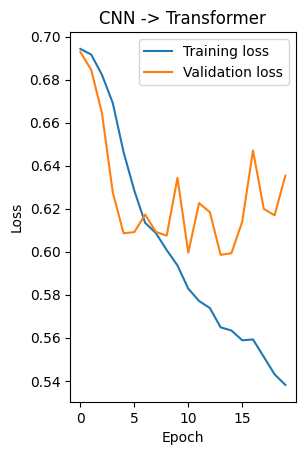

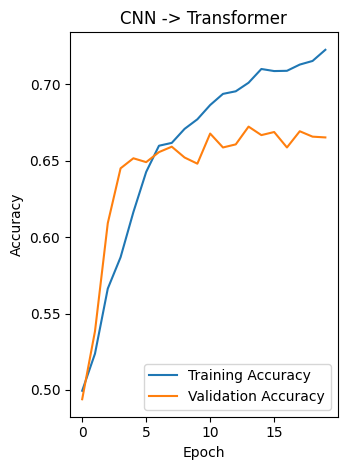

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_Transformer_right_left_imagine.pt


Training CNN -> LSTM -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.698, train accuracy = 0.501, val loss = 0.693, val accuracy = 0.506
Epoch 2: Train loss = 0.694, train accuracy = 0.507, val loss = 0.694, val accuracy = 0.494
Epoch 3: Train loss = 0.690, train accuracy = 0.529, val loss = 0.672, val accuracy = 0.601
Epoch 4: Train loss = 0.656, train accuracy = 0.602, val loss = 0.644, val accuracy = 0.630
Epoch 5: Train loss = 0.628, train accuracy = 0.632, val loss = 0.596, val accuracy = 0.650
Epoch 6: Train loss = 0.602, train accuracy = 0.661, val loss = 0.579, val accuracy = 0.675
Epoch 7: Train loss = 0.572, train accuracy = 0.683, val loss = 0.619, val accuracy = 0.674
Epoch 8: Train loss = 0.559, train accuracy = 0.696, val loss = 0.571, val accuracy = 0.686
Epoch 9: Train loss = 0.540, train accuracy = 0.715, val loss = 0.573, val accuracy = 0.669
Epoch 10: Train loss = 0.527, train accuracy = 0.726, val loss = 0.609, val accuracy = 0.680
Epoch 11: Train loss = 0.519, train accuracy = 0.722, val loss = 0.585, val acc

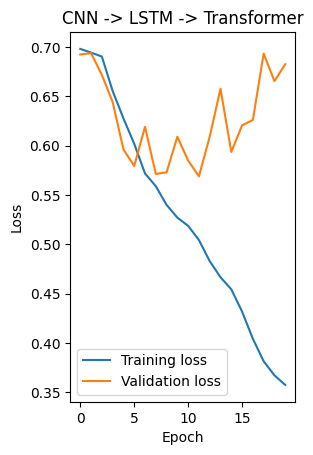

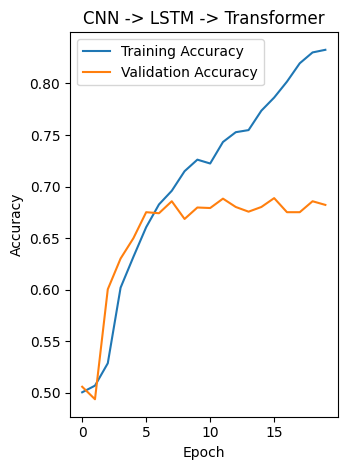

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_right_left_imagine.pt


In [ ]:
lstm_path = train_evaluate(model = cnn_bilstm(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM')
tf_path = train_evaluate(model = cnn_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> Transformer')
lstmtf_path = train_evaluate(model = cnn_bilstm_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM -> Transformer')


Test Accuracy: 0.652
Balanced Accuracy: 0.653
Macro F1 Score: 0.647
Binary AUC: 0.731


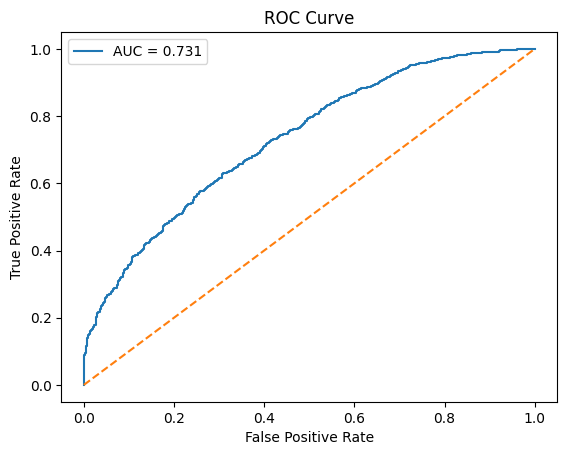

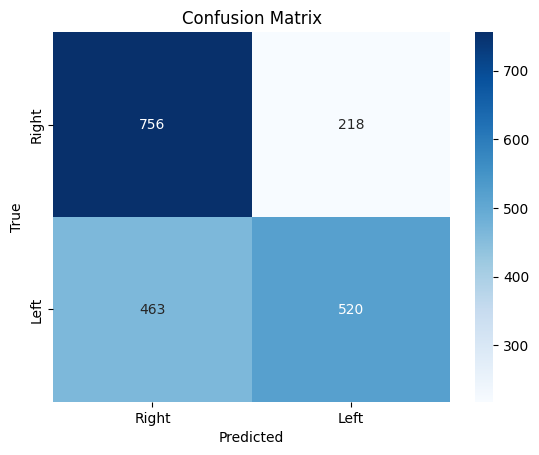


Test Accuracy: 0.632
Balanced Accuracy: 0.632
Macro F1 Score: 0.631
Binary AUC: 0.687


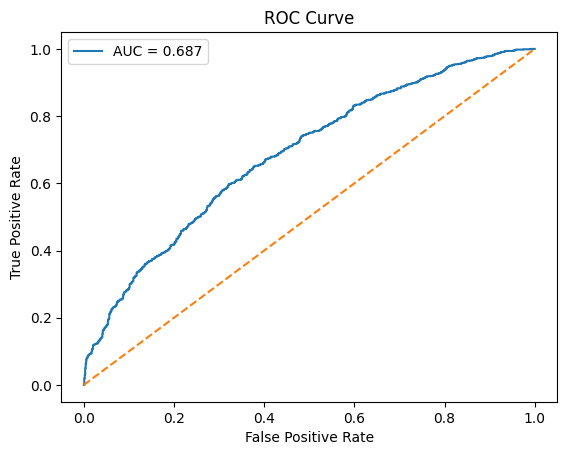

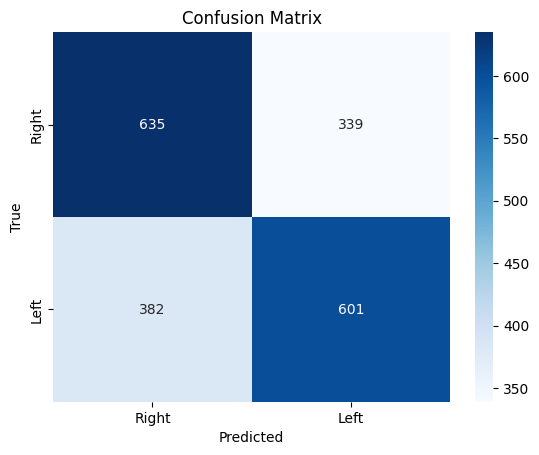


Test Accuracy: 0.648
Balanced Accuracy: 0.649
Macro F1 Score: 0.648
Binary AUC: 0.729


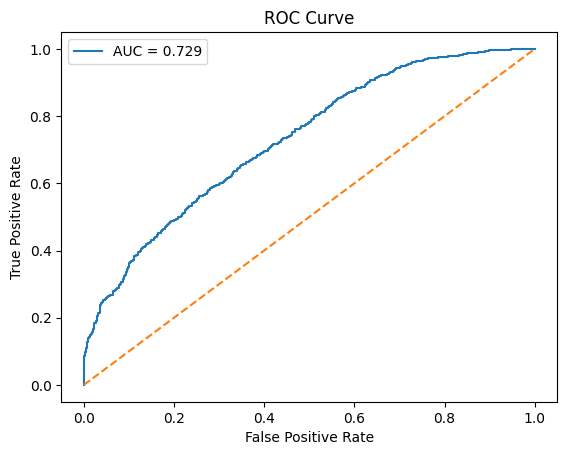

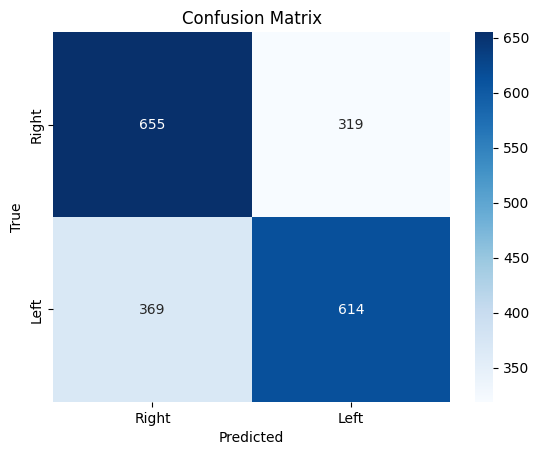

In [ ]:
resuls_cnn_lstm = test_model(model = cnn_bilstm(n_classes), model_path = lstm_path,
                            test_loader = test_loader, class_names = ["Right", "Left"])
resuls_cnn_tf = test_model(model = cnn_transformer(n_classes), model_path = tf_path,
                            test_loader = test_loader, class_names = ["Right", "Left"])
resuls_cnn_lstm_tf = test_model(model = cnn_bilstm_transformer(n_classes), model_path = lstmtf_path,
                            test_loader = test_loader, class_names = ["Right", "Left"])

# Three below are all separate

Training CNN -> LSTM:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 1.754, train accuracy = 0.486, val loss = 1.686, val accuracy = 0.500
Epoch 2: Train loss = 1.688, train accuracy = 0.490, val loss = 1.666, val accuracy = 0.500
Epoch 3: Train loss = 1.667, train accuracy = 0.490, val loss = 1.671, val accuracy = 0.500
Epoch 4: Train loss = 1.648, train accuracy = 0.491, val loss = 1.680, val accuracy = 0.500
Epoch 5: Train loss = 1.634, train accuracy = 0.491, val loss = 1.643, val accuracy = 0.499
Epoch 6: Train loss = 1.623, train accuracy = 0.492, val loss = 1.641, val accuracy = 0.493
Epoch 7: Train loss = 1.604, train accuracy = 0.494, val loss = 1.620, val accuracy = 0.494
Epoch 8: Train loss = 1.582, train accuracy = 0.497, val loss = 1.597, val accuracy = 0.488
Epoch 9: Train loss = 1.554, train accuracy = 0.504, val loss = 1.574, val accuracy = 0.504
Epoch 10: Train loss = 1.527, train accuracy = 0.508, val loss = 1.542, val accuracy = 0.510
Epoch 11: Train loss = 1.507, train accuracy = 0.514, val loss = 1.541, val acc

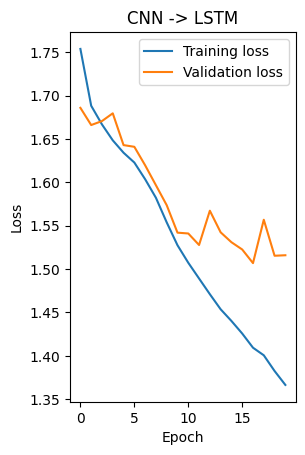

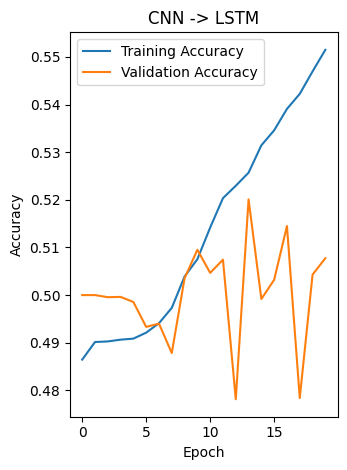

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_all.pt


Training CNN -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 1.749, train accuracy = 0.488, val loss = 1.702, val accuracy = 0.500
Epoch 2: Train loss = 1.701, train accuracy = 0.490, val loss = 1.666, val accuracy = 0.500
Epoch 3: Train loss = 1.661, train accuracy = 0.490, val loss = 1.650, val accuracy = 0.500
Epoch 4: Train loss = 1.636, train accuracy = 0.491, val loss = 1.630, val accuracy = 0.492
Epoch 5: Train loss = 1.616, train accuracy = 0.493, val loss = 1.621, val accuracy = 0.498
Epoch 6: Train loss = 1.599, train accuracy = 0.494, val loss = 1.629, val accuracy = 0.494
Epoch 7: Train loss = 1.583, train accuracy = 0.496, val loss = 1.618, val accuracy = 0.488
Epoch 8: Train loss = 1.571, train accuracy = 0.496, val loss = 1.615, val accuracy = 0.486
Epoch 9: Train loss = 1.559, train accuracy = 0.498, val loss = 1.602, val accuracy = 0.492
Epoch 10: Train loss = 1.549, train accuracy = 0.500, val loss = 1.612, val accuracy = 0.480
Epoch 11: Train loss = 1.538, train accuracy = 0.502, val loss = 1.607, val acc

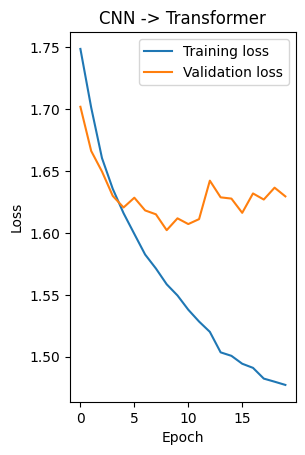

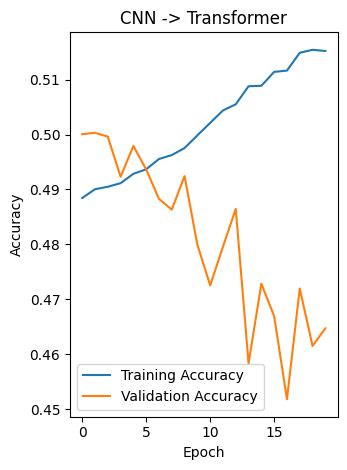

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_Transformer_all.pt


Training CNN -> LSTM -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 1.744, train accuracy = 0.490, val loss = 1.673, val accuracy = 0.500
Epoch 2: Train loss = 1.669, train accuracy = 0.491, val loss = 1.602, val accuracy = 0.502
Epoch 3: Train loss = 1.600, train accuracy = 0.497, val loss = 1.583, val accuracy = 0.499
Epoch 4: Train loss = 1.554, train accuracy = 0.505, val loss = 1.553, val accuracy = 0.510
Epoch 5: Train loss = 1.520, train accuracy = 0.513, val loss = 1.528, val accuracy = 0.516
Epoch 6: Train loss = 1.488, train accuracy = 0.520, val loss = 1.538, val accuracy = 0.518
Epoch 7: Train loss = 1.457, train accuracy = 0.527, val loss = 1.532, val accuracy = 0.508
Epoch 8: Train loss = 1.425, train accuracy = 0.538, val loss = 1.545, val accuracy = 0.510
Epoch 9: Train loss = 1.397, train accuracy = 0.544, val loss = 1.580, val accuracy = 0.482
Epoch 10: Train loss = 1.339, train accuracy = 0.559, val loss = 1.561, val accuracy = 0.504
Epoch 11: Train loss = 1.312, train accuracy = 0.568, val loss = 1.605, val acc

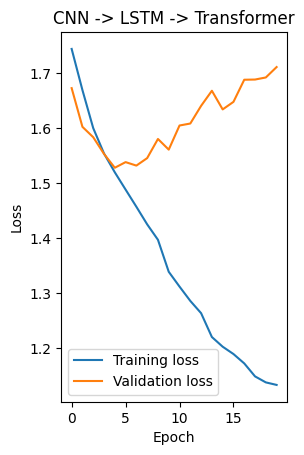

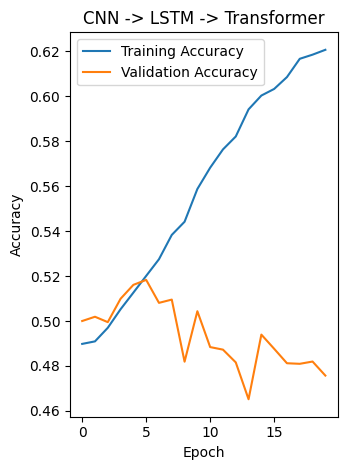

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_all.pt


In [ ]:
lstm_path = train_evaluate(model = cnn_bilstm(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM')
tf_path = train_evaluate(model = cnn_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> Transformer')
lstmtf_path = train_evaluate(model = cnn_bilstm_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM -> Transformer')


Test Accuracy: 0.490
Balanced Accuracy: 0.210
Macro F1 Score: 0.219
Multiclass AUC (macro OVR): 0.722


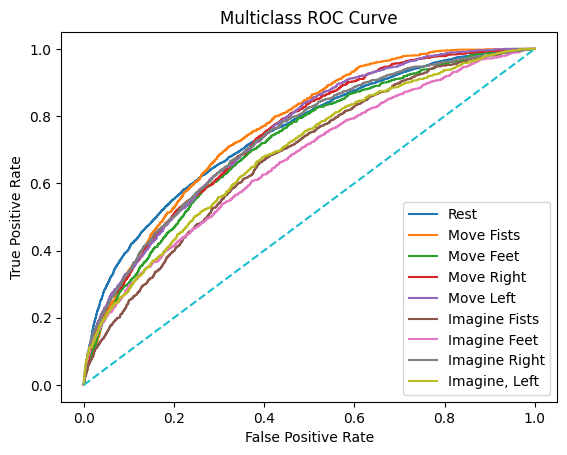

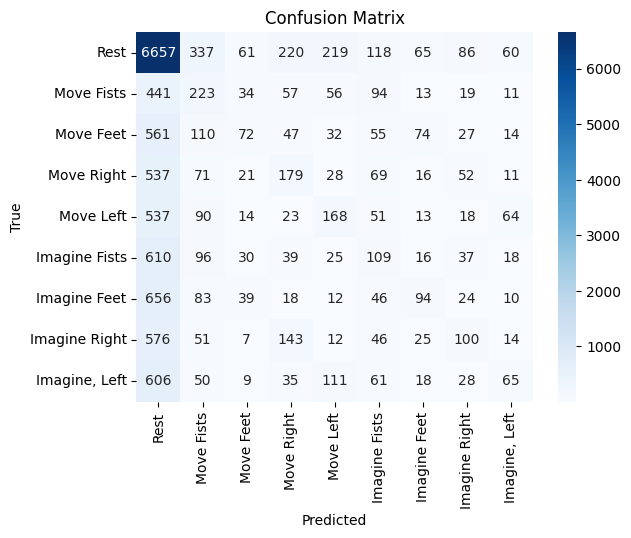


Test Accuracy: 0.490
Balanced Accuracy: 0.137
Macro F1 Score: 0.118
Multiclass AUC (macro OVR): 0.684


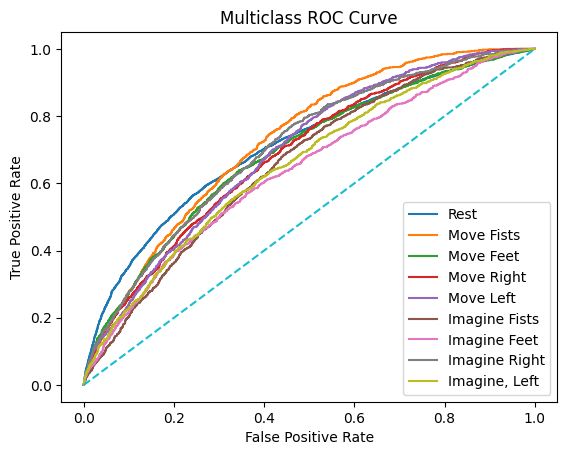

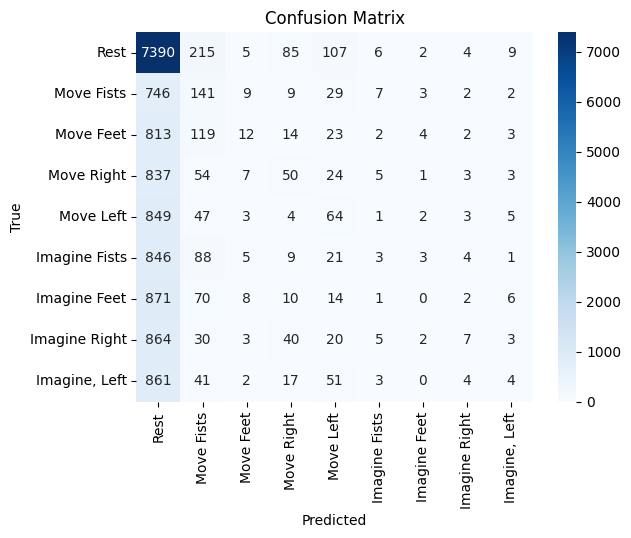


Test Accuracy: 0.502
Balanced Accuracy: 0.162
Macro F1 Score: 0.163
Multiclass AUC (macro OVR): 0.708


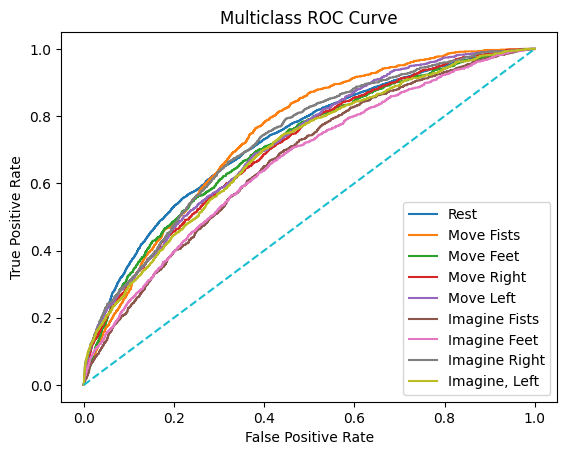

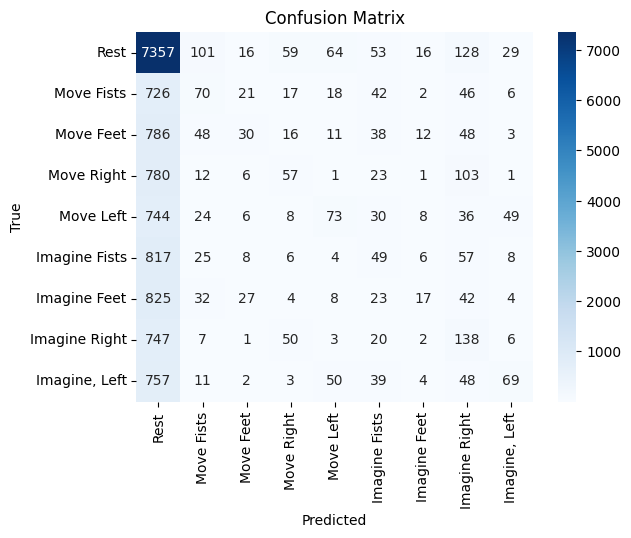

In [ ]:
resuls_cnn_lstm = test_model(model = cnn_bilstm(n_classes), model_path = lstm_path,
                            test_loader = test_loader, class_names = ["Rest", "Move Fists", "Move Feet", "Move Right", "Move Left", "Imagine Fists", "Imagine Feet", "Imagine Right", "Imagine, Left"])
resuls_cnn_tf = test_model(model = cnn_transformer(n_classes), model_path = tf_path,
                            test_loader = test_loader, class_names = ["Rest", "Move Fists", "Move Feet", "Move Right", "Move Left", "Imagine Fists", "Imagine Feet", "Imagine Right", "Imagine, Left"])
resuls_cnn_lstm_tf = test_model(model = cnn_bilstm_transformer(n_classes), model_path = lstmtf_path,
                            test_loader = test_loader, class_names = ["Rest", "Move Fists", "Move Feet", "Move Right", "Move Left", "Imagine Fists", "Imagine Feet", "Imagine Right", "Imagine, Left"])

# Three below are move vs imagine

Training CNN -> LSTM:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.681, train accuracy = 0.561, val loss = 0.681, val accuracy = 0.557
Epoch 2: Train loss = 0.672, train accuracy = 0.592, val loss = 0.673, val accuracy = 0.572
Epoch 3: Train loss = 0.662, train accuracy = 0.604, val loss = 0.671, val accuracy = 0.587
Epoch 4: Train loss = 0.651, train accuracy = 0.619, val loss = 0.669, val accuracy = 0.583
Epoch 5: Train loss = 0.639, train accuracy = 0.635, val loss = 0.672, val accuracy = 0.586
Epoch 6: Train loss = 0.628, train accuracy = 0.647, val loss = 0.676, val accuracy = 0.590
Epoch 7: Train loss = 0.620, train accuracy = 0.654, val loss = 0.674, val accuracy = 0.595
Epoch 8: Train loss = 0.609, train accuracy = 0.662, val loss = 0.671, val accuracy = 0.594
Epoch 9: Train loss = 0.595, train accuracy = 0.679, val loss = 0.690, val accuracy = 0.600
Epoch 10: Train loss = 0.591, train accuracy = 0.679, val loss = 0.678, val accuracy = 0.602
Epoch 11: Train loss = 0.583, train accuracy = 0.689, val loss = 0.677, val acc

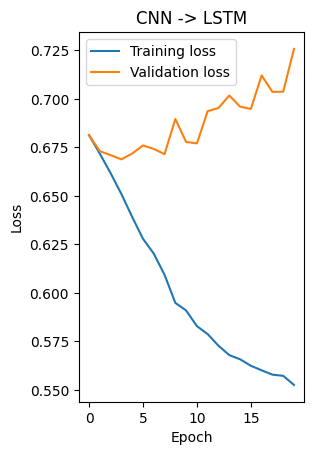

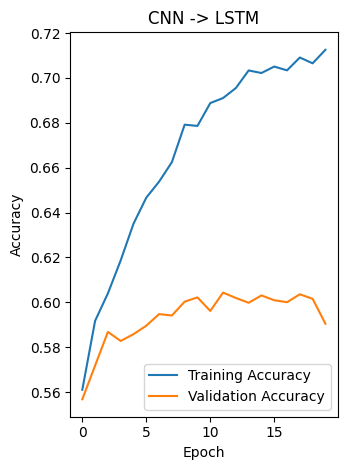

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_move_imagine.pt


Training CNN -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.680, train accuracy = 0.566, val loss = 0.689, val accuracy = 0.557
Epoch 2: Train loss = 0.669, train accuracy = 0.591, val loss = 0.679, val accuracy = 0.571
Epoch 3: Train loss = 0.655, train accuracy = 0.610, val loss = 0.672, val accuracy = 0.595
Epoch 4: Train loss = 0.645, train accuracy = 0.622, val loss = 0.673, val accuracy = 0.592
Epoch 5: Train loss = 0.637, train accuracy = 0.633, val loss = 0.675, val accuracy = 0.598
Epoch 6: Train loss = 0.628, train accuracy = 0.642, val loss = 0.685, val accuracy = 0.593
Epoch 7: Train loss = 0.625, train accuracy = 0.648, val loss = 0.707, val accuracy = 0.590
Epoch 8: Train loss = 0.614, train accuracy = 0.659, val loss = 0.697, val accuracy = 0.600
Epoch 9: Train loss = 0.613, train accuracy = 0.658, val loss = 0.699, val accuracy = 0.598
Epoch 10: Train loss = 0.610, train accuracy = 0.660, val loss = 0.693, val accuracy = 0.600
Epoch 11: Train loss = 0.607, train accuracy = 0.665, val loss = 0.715, val acc

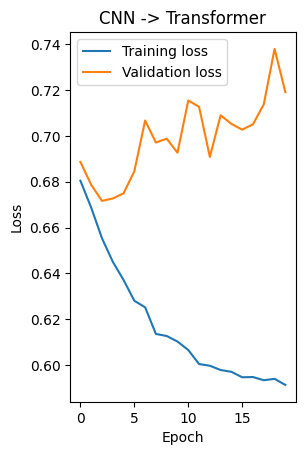

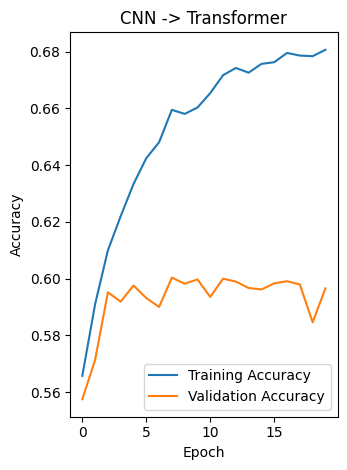

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_Transformer_move_imagine.pt


Training CNN -> LSTM -> Transformer:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train loss = 0.682, train accuracy = 0.565, val loss = 0.693, val accuracy = 0.563
Epoch 2: Train loss = 0.670, train accuracy = 0.591, val loss = 0.702, val accuracy = 0.544
Epoch 3: Train loss = 0.662, train accuracy = 0.601, val loss = 0.681, val accuracy = 0.573
Epoch 4: Train loss = 0.657, train accuracy = 0.610, val loss = 0.687, val accuracy = 0.562
Epoch 5: Train loss = 0.649, train accuracy = 0.618, val loss = 0.690, val accuracy = 0.586
Epoch 6: Train loss = 0.640, train accuracy = 0.629, val loss = 0.679, val accuracy = 0.576
Epoch 7: Train loss = 0.632, train accuracy = 0.638, val loss = 0.705, val accuracy = 0.588
Epoch 8: Train loss = 0.618, train accuracy = 0.652, val loss = 0.681, val accuracy = 0.583
Epoch 9: Train loss = 0.607, train accuracy = 0.666, val loss = 0.738, val accuracy = 0.580
Epoch 10: Train loss = 0.594, train accuracy = 0.676, val loss = 0.694, val accuracy = 0.568
Epoch 11: Train loss = 0.570, train accuracy = 0.699, val loss = 0.737, val acc

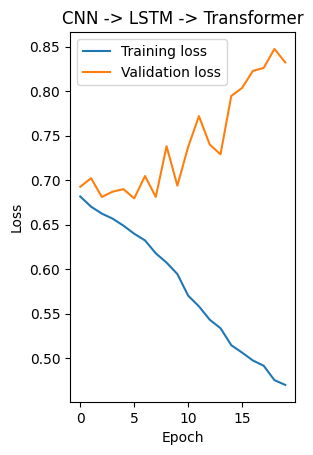

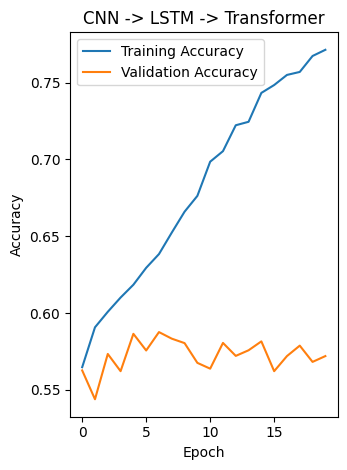

Best model saved to /content/drive/MyDrive/Project/files/CNN_->_LSTM_->_Transformer_move_imagine.pt


In [ ]:
lstm_path = train_evaluate(model = cnn_bilstm(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM')
tf_path = train_evaluate(model = cnn_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> Transformer')
lstmtf_path = train_evaluate(model = cnn_bilstm_transformer(n_classes = n_classes), train_loader = train_loader,
                                  val_loader = val_loader, model_name = 'CNN -> LSTM -> Transformer')


Test Accuracy: 0.574
Balanced Accuracy: 0.574
Macro F1 Score: 0.565
Binary AUC: 0.622


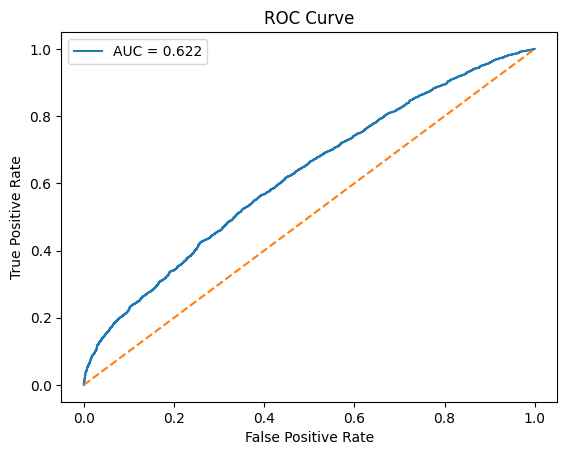

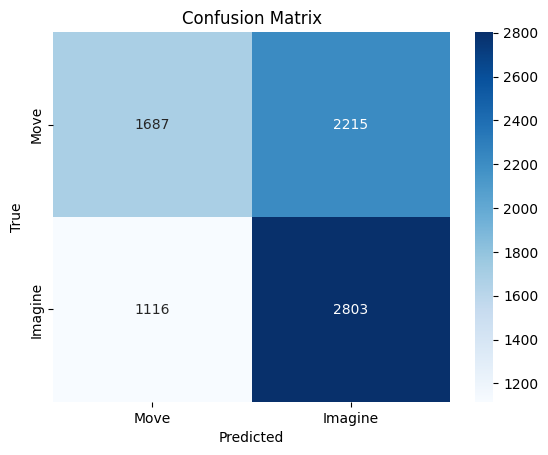


Test Accuracy: 0.573
Balanced Accuracy: 0.573
Macro F1 Score: 0.569
Binary AUC: 0.615


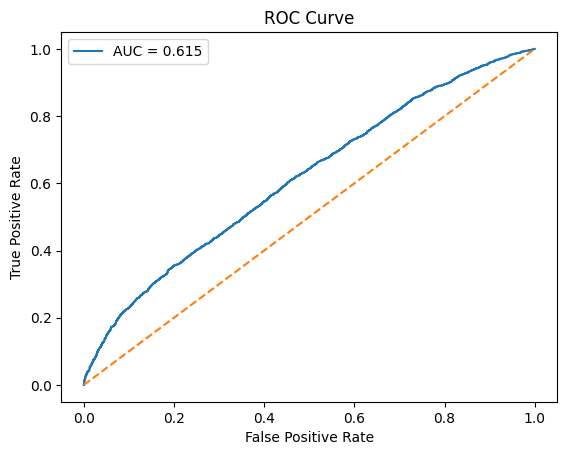

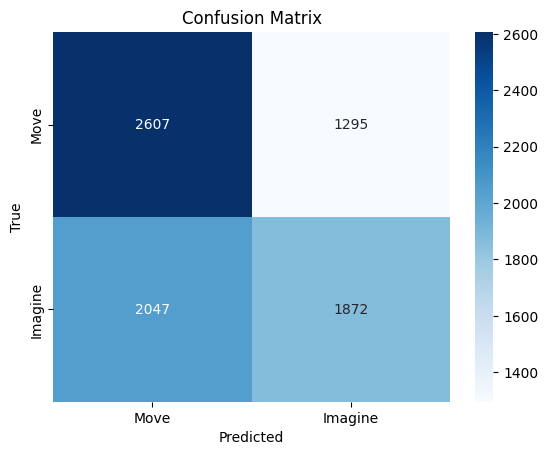


Test Accuracy: 0.581
Balanced Accuracy: 0.580
Macro F1 Score: 0.565
Binary AUC: 0.621


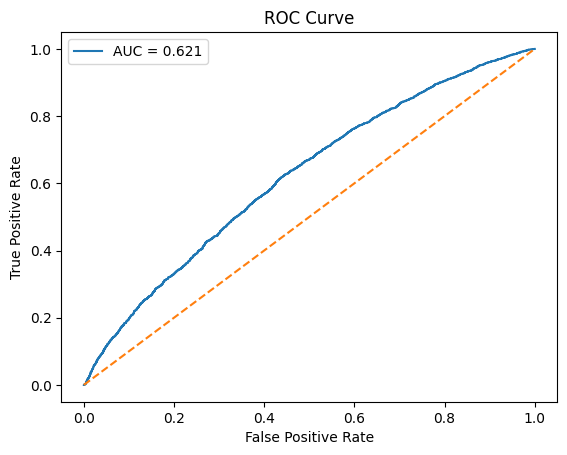

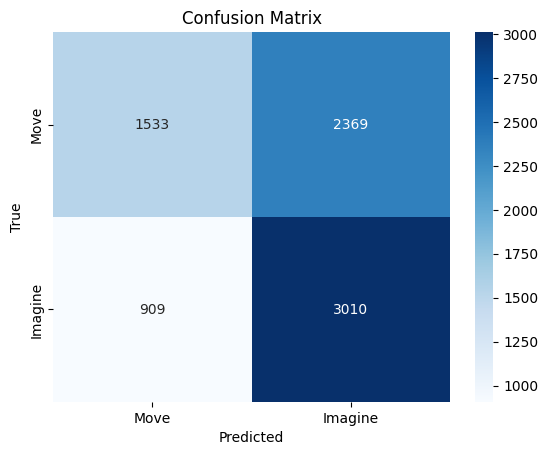

In [ ]:
resuls_cnn_lstm = test_model(model = cnn_bilstm(n_classes), model_path = lstm_path,
                            test_loader = test_loader, class_names = ["Move", "Imagine"])
resuls_cnn_tf = test_model(model = cnn_transformer(n_classes), model_path = tf_path,
                            test_loader = test_loader, class_names = ["Move", "Imagine"])
resuls_cnn_lstm_tf = test_model(model = cnn_bilstm_transformer(n_classes), model_path = lstmtf_path,
                            test_loader = test_loader, class_names = ["Move", "Imagine"])